# Setup

In [1]:
from IPython.display import display

from brightway2 import *
import bw2analyzer as bwa
import brightway2 as bw
from bw2data.parameters import *
from lci_to_bw2 import *
from bw2data.project import ProjectManager
from bw2data.parameters import (ActivityParameter, DatabaseParameter,
                                ProjectParameter, Group)

import pandas as pd
import numpy as np

import math

import pathlib

import sqlite3

import os

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [2]:
# Directory with datasets:
ROOT_DIR = "files"

In [3]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)
pd.options.display.max_rows = 200

In [4]:
# Define path to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\IMG


In [5]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [6]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [7]:
# List of the available projects
bw.projects

Brightway2 projects manager with 5 objects:
	LCA_Glazing
	LCA_Glazing_0
	LCOPT_Setup
	default
	test
Use `projects.report()` to get a report on all projects.

In [8]:
# New project or access an existing one:
bw.projects.set_current("LCA_Glazing")

# Where the current project is:
bw.projects.dir

'C:\\Users\\souvi\\AppData\\Local\\pylca\\Brightway3\\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab'

**Abbreviation:**

- fg = flat glass
- inv = inventory
- act = activity
- norm = normalised impacts
- ia = impact assessment
- fu = functional unit
- igu = insulating glass unit

# List of Scenarios with their Parameters

Import the Excel file with the LCA scenarios (i.e. the values for the parameters to be used in BW2 and EnergyPlus):

In [9]:
LCA_scenarios = pd.ExcelFile(os.path.join(ROOT_DIR, "LCA_scenarios.xlsx"))

Define a series of dataframes for each step of calculation:

In [10]:
print("LCA_scenarios, sheet names = \n {}\n".format(LCA_scenarios.sheet_names))

LCA_scenarios, sheet names = 
 ['Scenarios', 'Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Step9', 'Step10', 'Step11', 'Step12', 'Step13', 'Step14', 'Step15', 'Step16', 'Step17', 'Step18', 'Step19']



In [11]:
# Create dataframe for with scenarios for each step:
df_step1 = LCA_scenarios.parse('Step1').set_index('name')
df_step2 = LCA_scenarios.parse('Step2').set_index('name')
df_step3 = LCA_scenarios.parse('Step3').set_index('name')
df_step4 = LCA_scenarios.parse('Step4').set_index('name')
df_step5 = LCA_scenarios.parse('Step5').set_index('name')
df_step6 = LCA_scenarios.parse('Step6').set_index('name')
df_step7 = LCA_scenarios.parse('Step7').set_index('name')
df_step8 = LCA_scenarios.parse('Step8').set_index('name')
df_step9 = LCA_scenarios.parse('Step9').set_index('name')
df_step10 = LCA_scenarios.parse('Step10').set_index('name')
df_step11 = LCA_scenarios.parse('Step11').set_index('name')
df_step12 = LCA_scenarios.parse('Step12').set_index('name')
df_step13 = LCA_scenarios.parse('Step13').set_index('name')
df_step14 = LCA_scenarios.parse('Step14').set_index('name')
df_step15 = LCA_scenarios.parse('Step15').set_index('name')
df_step16 = LCA_scenarios.parse('Step16').set_index('name')
df_step17 = LCA_scenarios.parse('Step17').set_index('name')
df_step18 = LCA_scenarios.parse('Step18').set_index('name')
df_step19 = LCA_scenarios.parse('Step19').set_index('name')

# Import of LCA Databases

In [12]:
# databases available in the current project:
bw.databases

Databases dictionary with 7 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_eol
	exldb_igu
	exldb_spacers

## Ecoinvent and Biosphere 3

**Importing Biosphere 3:**

In [13]:
# Importing elementary flows, LCIA methods and some other data
bw.bw2setup()

Biosphere database already present!!! No setup is needed


**Importing Ecoinvent 3.7, cut-off system model:**

For more information about the system models in ecoinvent 3, and especially the cut-off one, read [this](https://www.ecoinvent.org/database/system-models-in-ecoinvent-3/cut-off-system-model/allocation-cut-off-by-classification.html).

In [14]:
# Import ecoinvent 3.7 cut-off
ei37cutdir = r"C:\Users\souvi\Documents\These\80_Calculations\06_LCA_SystemDiagrams\02_Dataset\ecoinvent 3.7_cutoff_ecoSpold02\datasets"

if 'ecoinvent 3.7 cut-off' in databases:
    print("Database has already been imported!")
else:
    ei37cut = bw.SingleOutputEcospold2Importer(
        ei37cutdir, 'ecoinvent 3.7 cut-off')
    ei37cut.apply_strategies()
    ei37cut.statistics()
    ei37cut.write_database()

Database has already been imported!


## Excel datasets

<font color='red'>Do we need to import the Excel datasets?<font>

In [15]:
import_exldb = True

**Importing the Excel dataset relating to aluminium production:**

In [16]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_Alu.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

Extracted 2 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.24 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


2 datasets
12 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_alu.xlsx


0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 22:13:08
  Finished: 12/19/2021 22:13:08
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.21
Created database: exldb_alu


**Importing the Excel dataset relating to IGUs:**

In [17]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_IGU.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_alu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Add the project-level parameters:
    imp.write_project_parameters()

    # Write the data to a database to save it:
    imp.write_database()

Extracted 44 worksheets in 0.32 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.22 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
44 datasets
381 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_igu.xlsx


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 22:13:11
  Finished: 12/19/2021 22:13:11
  Total time elapsed: 00:00:00
  CPU %: 99.70
  Memory %: 1.38
Created database: exldb_igu


**Importing the Excel dataset relating to double glazing w/ different types of spacers:**

In [18]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_Spacers.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_igu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

Extracted 12 worksheets in 0.10 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.21 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
12 datasets
174 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_spacers.xlsx


0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 22:13:14
  Finished: 12/19/2021 22:13:14
  Total time elapsed: 00:00:00
  CPU %: 50.40
  Memory %: 1.34
Created database: exldb_spacers


**Importing the Excel dataset relating to curtain wall end-of-life phase:**

In [19]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_CW_EoL.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_cw",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

Extracted 26 worksheets in 0.16 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.20 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
26 datasets
100 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_cw_eol.xlsx


0% [##########################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 22:13:16
  Finished: 12/19/2021 22:13:16
  Total time elapsed: 00:00:00
  CPU %: 208.30
  Memory %: 1.35
Created database: exldb_cw_eol


**Importing the Excel dataset relating to curtain wall production and use:**

In [20]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "LCI_CW.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_igu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_alu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_cw_eol",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creation of an Excel sheet with process data:
    imp.write_excel()

    # Write the data to a database to save it:
    imp.write_database()

Extracted 48 worksheets in 0.26 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.28 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
48 datasets
259 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_cw.xlsx


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 22:13:19
  Finished: 12/19/2021 22:13:19
  Total time elapsed: 00:00:00
  CPU %: 75.60
  Memory %: 1.39
Created database: exldb_cw


**Checking if the imports went well:**

List databases:

In [21]:
bw.databases

Databases dictionary with 7 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_eol
	exldb_igu
	exldb_spacers

Checking Excel database:

**Deleting a database, if needed:**

## Navigate Databases

**Navigate Databases, assigning a variable to each one:**

In [22]:
eib3db = bw.Database('biosphere3')

eicutdb = bw.Database('ecoinvent 3.7 cut-off')

exldb_alu = bw.Database('exldb_alu')
exldb_igu = bw.Database('exldb_igu')
exldb_cw = bw.Database('exldb_cw')
exldb_spacers = bw.Database('exldb_spacers')
exldb_cw_eol = bw.Database('exldb_cw_eol')

# Define the Parameters

## Overview

**Checking the total number of parameters:**

In [23]:
len(parameters)

52

Look at the parameter directly:

In [24]:
print("Project parameters:")
for p in ProjectParameter.select():
    print(p.name, ":", round(p.amount, 2))

print("------")
print("Database parameters:")
for p in DatabaseParameter.select():
    print(p.database, " > ", p.name, ":", round(p.amount, 2))

print("------")
print("Activity parameters:")
for p in ActivityParameter.select():
    if "dummy" not in p.name:
        print(p.name, ":", round(p.amount, 2))

Project parameters:
param_g_density : 2.5
param_t_lsg : 10.0
param_t_tsg : 10.0
param_n_pvb : 2.0
param_d1 : 125.0
param_t_g_ext : 8.0
param_t_g_mid_tg : 6.0
param_t_g_uncoated_int : 8.0
------
Database parameters:
exldb_cw_eol  >  param_m_sg_g : 25.0
exldb_cw_eol  >  param_m_sg_alu : 3.31
exldb_cw_eol  >  param_m_sg_low_wood : 0.09
exldb_cw_eol  >  param_m_sg_low_silicone : 0.15
exldb_cw_eol  >  param_m_sg_high_epdm : 0.55
exldb_cw_eol  >  param_m_dg_g : 45.0
exldb_cw_eol  >  param_m_dg_alu : 3.47
exldb_cw_eol  >  param_m_dg_low_wood : 0.09
exldb_cw_eol  >  param_m_dg_low_silicone : 0.15
exldb_cw_eol  >  param_m_dg_high_epdm : 0.67
exldb_cw_eol  >  param_m_tg_g : 60.0
exldb_cw_eol  >  param_m_tg_alu : 3.79
exldb_cw_eol  >  param_m_tg_epdm : 0.78
exldb_cw_eol  >  param_m_ccf_g : 70.0
exldb_cw_eol  >  param_m_ccf_alu : 13.22
exldb_cw_eol  >  param_m_ccf_epdm : 1.95
exldb_cw_eol  >  param_m_vacuum_g : 45.0
exldb_cw_eol  >  param_m_smart_g : 45.0
exldb_cw_eol  >  param_m_smart_elec : 0.94

## Activate Parameters

**We have now to tell bw to activate the exchanges and their formulas:**

First, we tell the parameter code that these exchanges have formulas:

In [25]:
# Add exchanges with formulas from activity to group:
for act in exldb_igu:
    parameters.add_exchanges_to_group("igu_param_group", act)

In [26]:
ls_act_data_cw_eol = []
n_code = 0
for obj in DatabaseParameter.select().where(
        DatabaseParameter.database == "exldb_cw_eol"):
    ls_act_data_cw_eol.append({'name': obj.name, 'amount': obj.amount,
                               'formula': obj.formula, 'database': obj.database,
                              'code': "p_eol_"+str(n_code)})
    n_code += 1

parameters.new_activity_parameters(
    ls_act_data_cw_eol, "cw_eol_param_group", overwrite=True)

In [27]:
for act in exldb_cw_eol:
    parameters.add_exchanges_to_group("cw_eol_param_group", act)

In [28]:
ls_act_data_cw = []
n_code = 0
for obj in DatabaseParameter.select().where(
        DatabaseParameter.database == "exldb_cw"):
    ls_act_data_cw.append({'name': obj.name, 'amount': obj.amount,
                           'formula': obj.formula, 'database': obj.database,
                           'code': "p_"+str(n_code)})
    n_code += 1

parameters.new_activity_parameters(
    ls_act_data_cw, "cw_use_param_group", overwrite=True)

In [29]:
for act in exldb_cw:
    parameters.add_exchanges_to_group("cw_use_param_group", act)

Then we calculate the "activated" formula values:

In [30]:
ActivityParameter.recalculate_exchanges("igu_param_group")
ActivityParameter.recalculate_exchanges("cw_use_param_group")
ActivityParameter.recalculate_exchanges("cw_eol_param_group")

**Delete the parameters:**

# LCIA Methods

List of available LCIA methods:

Define methods:

In [31]:
method_ilcd_gwp = (
    'ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')

In [32]:
methods_small = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

In [33]:
methods_full = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'dissipated water'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

# LCA of Glass Sheets and IGUs from Cradle to Gate

## Flat glass production

Define the <font color='red'> functional unit </font> per flat glass (fg) type:

In [34]:
inv_fg_unsorted = [act for act in exldb_igu
                   if 'market for flat glass' in act['name']
                   ]

inv_fg = sorted(inv_fg_unsorted,
                key=lambda k: k['name'])

inv_fg

['market for flat glass, coated' (kilogram, BE, ('building components', 'windows')),
 'market for flat glass, uncoated' (kilogram, BE, ('building components', 'windows'))]

In [35]:
names_fg_processed = ['market for laminated safety glass',
                      'market for tempered safety glass',
                      'market for smart glass'
                      ]

inv_fg_processed_unsorted = [act for act in exldb_igu
                             for n in names_fg_processed
                             if n in act['name']
                             and "glazing" not in act['name']
                             ]

inv_fg_processed = sorted(inv_fg_processed_unsorted,
                          key=lambda k: k['name'])

inv_fg_processed

['market for laminated safety glass' (square meter, BE, ('building components', 'windows')),
 'market for laminated safety glass, coated' (square meter, BE, ('building components', 'windows')),
 'market for smart glass' (square meter, BE, ('building components', 'windows')),
 'market for tempered safety glass' (square meter, BE, ('building components', 'windows')),
 'market for tempered safety glass, coated' (square meter, BE, ('building components', 'windows'))]

In [36]:
# functional unit; 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25
# functional unit; 1m²:
fu_fg_processed = 1

impacts_fg = []

for act in inv_fg:
    lca = bw.LCA({act: fu_fg})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_fg.append((act["name"], act["location"],
                           method[1].title(), lca.score,
                           bw.methods.get(method).get('unit')))

for act in inv_fg_processed:
    lca = bw.LCA({act: fu_fg_processed})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_fg.append((act["name"], act["location"],
                           method[1].title(), lca.score,
                           bw.methods.get(method).get('unit')))

# impacts_fg

In [37]:
df_impacts_fg = pd.DataFrame(impacts_fg, columns=["Name", "Location", "Method",
                                                  "Score", "Unit"])

df_impacts_fg = pd.pivot_table(df_impacts_fg, index=["Name"],
                               columns=["Method", "Unit"],
                               values="Score")

In [38]:
df_impacts_fg = df_impacts_fg.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

df_impacts_fg.round(2)

Method                                    Climate Change Ecosystem Quality  \
Unit                                           kg CO2-Eq               CTU   
Name                                                                         
market for flat glass, uncoated                    27.51              7.51   
market for flat glass, coated                      29.12              9.58   
market for tempered safety glass                   29.63              7.74   
market for tempered safety glass, coated           31.27              9.85   
market for laminated safety glass                  37.33             12.78   
market for laminated safety glass, coated          38.16             13.83   
market for smart glass                            543.25           1339.11   

Method                                                                \
Unit                                      kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                   
market for flat glass, uncoated              0.00      0.23     0.61   
market for flat glass, coated                0.00      0.24     0.64   
market for tempered safety glass             0.00      0.23     0.63   
market for tempered safety glass, coated     0.00      0.25     0.66   
market for laminated safety glass            0.01      0.26     0.70   
market for laminated safety glass, coated    0.01      0.27     0.71   
market for smart glass                       0.04      2.28     7.40   

Method                                    Human Health            Resources  \
Unit                                        kg CFC-11. kg NMVOC-. megajoule   
Name                                                                          
market for flat glass, uncoated                    0.0       0.15    349.20   
market for flat glass, coated                      0.0       0.15    382.46   
market for tempered safety glass                   0.0       0.15    382.10   
market for tempered safety glass, coated           0.0       0.16    416.02   
market for laminated safety glass                  0.0       0.17    628.82   
market for laminated safety glass, coated          0.0       0.17    645.78   
market for smart glass                             0.0       2.22   8468.86   

Method                                              
Unit                                        points  
Name                                                
market for flat glass, uncoated             146.46  
market for flat glass, coated               189.15  
market for tempered safety glass            149.70  
market for tempered safety glass, coated    193.24  
market for laminated safety glass           239.95  
market for laminated safety glass, coated   261.72  
market for smart glass                     7924.06

In [39]:
df_impacts_fg = df_impacts_fg.reset_index()
df_impacts_fg['Name'] = (df_impacts_fg['Name']
                         .str.replace('market for ', ''))

df_impacts_fg = df_impacts_fg.set_index('Name')

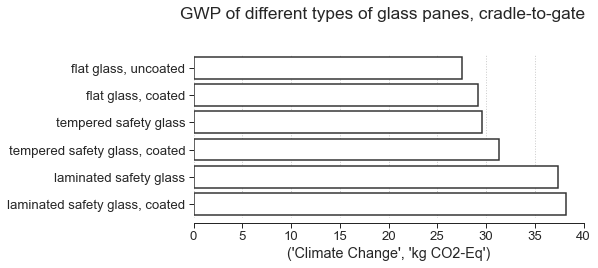

In [40]:
fig, ax = plt.subplots(figsize=(7, 3))

df_impacts_wo_smartg = df_impacts_fg.drop("smart glass", axis=0)

sns.barplot(data=df_impacts_wo_smartg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_wo_smartg.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

In [41]:
df_norm_impacts_wo_smartg = (
    df_impacts_wo_smartg / df_impacts_wo_smartg.max()
)
df_norm_impacts_wo_smartg.round(2)

Method                         Climate Change Ecosystem Quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.72              0.54    0.47   
flat glass, coated                       0.76              0.69    0.59   
tempered safety glass                    0.78              0.56    0.49   
tempered safety glass, coated            0.82              0.71    0.61   
laminated safety glass                   0.98              0.92    0.94   
laminated safety glass, coated           1.00              1.00    1.00   

Method                                            Human Health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.84     0.86         0.49       0.84   
flat glass, coated                  0.89     0.90         0.52       0.88   
tempered safety glass               0.86     0.88         0.54       0.86   
tempered safety glass, coated       0.91     0.93         0.57       0.90   
laminated safety glass              0.97     0.98         0.99       0.98   
laminated safety glass, coated      1.00     1.00         1.00       1.00   

Method                         Resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.54   0.56  
flat glass, coated                  0.59   0.72  
tempered safety glass               0.59   0.57  
tempered safety glass, coated       0.64   0.74  
laminated safety glass              0.97   0.92  
laminated safety glass, coated      1.00   1.00

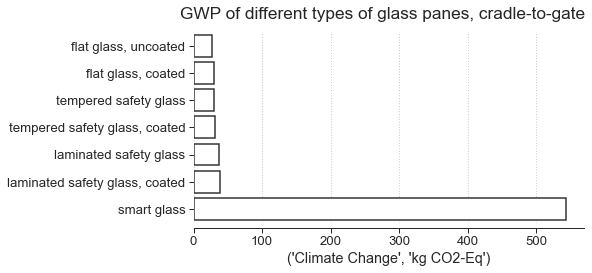

In [42]:
fig, ax = plt.subplots(figsize=(7, 3.5))

sns.barplot(data=df_impacts_fg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_fg.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate')
sns.despine(left=True, offset=5)
plt.show()

In [43]:
df_norm_impacts_fg = df_impacts_fg / df_impacts_fg.max()
df_norm_impacts_fg.round(2)

Method                         Climate Change Ecosystem Quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.05              0.01    0.06   
flat glass, coated                       0.05              0.01    0.08   
tempered safety glass                    0.05              0.01    0.06   
tempered safety glass, coated            0.06              0.01    0.08   
laminated safety glass                   0.07              0.01    0.12   
laminated safety glass, coated           0.07              0.01    0.13   
smart glass                              1.00              1.00    1.00   

Method                                            Human Health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.10     0.08         0.02       0.07   
flat glass, coated                  0.11     0.09         0.02       0.07   
tempered safety glass               0.10     0.09         0.02       0.07   
tempered safety glass, coated       0.11     0.09         0.03       0.07   
laminated safety glass              0.12     0.09         0.04       0.08   
laminated safety glass, coated      0.12     0.10         0.05       0.08   
smart glass                         1.00     1.00         1.00       1.00   

Method                         Resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.04   0.02  
flat glass, coated                  0.05   0.02  
tempered safety glass               0.05   0.02  
tempered safety glass, coated       0.05   0.02  
laminated safety glass              0.07   0.03  
laminated safety glass, coated      0.08   0.03  
smart glass                         1.00   1.00

**Same calculation, but using the MultiLCA class:**

In [44]:
# functional unit; 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25
# functional unit; 1m²:
fu_fg_processed = 1

mlca_syst_fg = []

for act in inv_fg:
    mlca_syst_fg.append({act.key: fu_fg})

for act in inv_fg_processed:
    mlca_syst_fg.append({act.key: fu_fg_processed})

mlca_syst_fg

[{('exldb_igu', 'market_glass_coated'): 25},
 {('exldb_igu', 'market_glass_uncoated'): 25},
 {('exldb_igu', 'market_lsg'): 1},
 {('exldb_igu', 'market_lsg_coated'): 1},
 {('exldb_igu', 'market_smartglass'): 1},
 {('exldb_igu', 'market_tsg'): 1},
 {('exldb_igu', 'market_tsg_coated'): 1}]

In [45]:
bw.calculation_setups['calculation_setup'] = {'inv': mlca_syst_fg,
                                              'ia': methods_small}

mlca = bw.MultiLCA('calculation_setup')
df_impacts_mlca_fg = pd.DataFrame(data=mlca.results, columns=mlca.methods)

In [46]:
activities = [(get_activity(key), amount)
              for dct in mlca.func_units
              for key, amount in dct.items()
              ]

df_fu = pd.DataFrame([(x['name'], x['database'], x['code'],
                       x['location'], x['unit'], y)
                      for x, y in activities],
                     columns=('Database', 'Code', 'Name',
                              'Location', 'Unit', 'Amount')
                     )

df_impacts_mlca_fg_expanded = pd.concat(
    [df_fu, df_impacts_mlca_fg], axis=1
)

In [47]:
df_impacts_mlca_fg_expanded = (
    df_impacts_mlca_fg_expanded.set_index("Name")
    .drop(["Database", "Code", "Location"], axis=1).round(2)
)

In [48]:
df_impacts_mlca_fg_expanded.sort_values(
    by=[('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')],
    ascending=True)

,Unit,Amount,"(ILCD 2.0 2018 midpoint, climate change, climate change total)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater ecotoxicity)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater and terrestrial acidification)","(ILCD 2.0 2018 midpoint, ecosystem quality, freshwater eutrophication)","(ILCD 2.0 2018 midpoint, ecosystem quality, terrestrial eutrophication)","(ILCD 2.0 2018 midpoint, human health, ozone layer depletion)","(ILCD 2.0 2018 midpoint, human health, photochemical ozone creation)","(ILCD 2.0 2018 midpoint, resources, fossils)","(ILCD 2.0 2018 midpoint, resources, land use)"
Name,,,,,,,,,,,
market_glass_uncoated,kilogram,25,27.51,7.51,0.23,0.00,0.61,0.0,0.15,349.20,146.46
market_glass_coated,kilogram,25,29.12,9.58,0.24,0.00,0.64,0.0,0.15,382.46,189.15
market_tsg,square meter,1,29.63,7.74,0.23,0.00,0.63,0.0,0.15,382.10,149.70
market_tsg_coated,square meter,1,31.27,9.85,0.25,0.00,0.66,0.0,0.16,416.02,193.24
market_lsg,square meter,1,37.33,12.78,0.26,0.01,0.70,0.0,0.17,628.82,239.95
market_lsg_coated,square meter,1,38.16,13.83,0.27,0.01,0.71,0.0,0.17,645.78,261.72
market_smartglass,square meter,1,543.25,1339.11,2.28,0.04,7.40,0.0,2.22,8468.86,7924.06


## Analysis of the Impact of Different Types of Spacers, Sealants and Insulating Gases, Cradle-to-Gate

**Comparative analysis of different spacers:**

In [49]:
inv_spacers = [act for act in bw.Database("exldb_spacers")
               if 'krypton' not in act['name']
               and 'xenon' not in act['name']
               and 'air' not in act['name']]

fu_spacers = [{igu: 1} for igu in inv_spacers]

In [50]:
impacts_spacers = []

for igu in inv_spacers:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_spacers.append((igu["name"], igu["location"],
                                method[1].title(), lca.score,
                                bw.methods.get(method).get('unit')))

# impacts_spacers

In [51]:
df_impacts_spacers = pd.DataFrame(
    impacts_spacers,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_spacers = pd.pivot_table(
    df_impacts_spacers, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [52]:
df_impacts_spacers = df_impacts_spacers.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_spacers = df_impacts_spacers.reset_index()
df_impacts_spacers['Name'] = (df_impacts_spacers['Name']
                              .str.replace('double glazing production, ', '')
                              .str.replace(', argon', ''))

df_impacts_spacers = df_impacts_spacers.set_index('Name')

In [53]:
df_impacts_spacers.round(2)

Method                          Climate Change Ecosystem Quality          \
Unit                                 kg CO2-Eq               CTU kg P-Eq   
Name                                                                       
composite with corrugated metal          47.02             14.81    0.01   
epdm foam                                47.11             15.31    0.01   
single-seal aluminium                    47.23             17.50    0.01   
dual-seal aluminium                      47.31             17.57    0.01   
dual-seal steel                          47.32             17.81    0.01   
thermally broken aluminium               47.48             17.58    0.01   
thermoplastic PIB                        47.57             15.64    0.01   
slicone foam                             48.79             16.10    0.01   
dual-seal composite plastic              60.87             20.15    0.01   

Method                                             Human Health             \
Unit                            mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                         
composite with corrugated metal      0.38     1.02          0.0       0.24   
epdm foam                            0.38     1.02          0.0       0.24   
single-seal aluminium                0.38     1.02          0.0       0.24   
dual-seal aluminium                  0.38     1.03          0.0       0.24   
dual-seal steel                      0.38     1.03          0.0       0.24   
thermally broken aluminium           0.38     1.03          0.0       0.25   
thermoplastic PIB                    0.38     1.03          0.0       0.24   
slicone foam                         0.39     1.04          0.0       0.25   
dual-seal composite plastic          0.46     1.15          0.0       0.28   

Method                          Resources          
Unit                            megajoule  points  
Name                                               
composite with corrugated metal    644.73  284.57  
epdm foam                          636.86  287.71  
single-seal aluminium              634.99  290.38  
dual-seal aluminium                637.45  291.08  
dual-seal steel                    637.49  291.33  
thermally broken aluminium         641.65  291.87  
thermoplastic PIB                  643.67  293.18  
slicone foam                       666.35  301.75  
dual-seal composite plastic        832.85  383.12

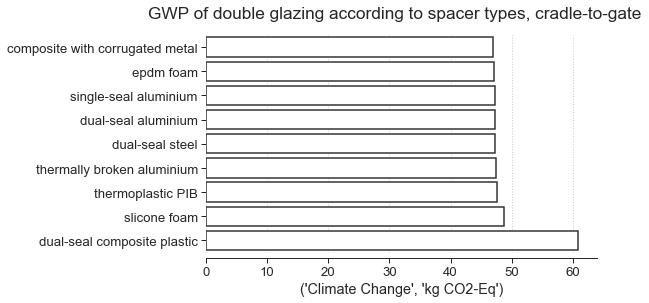

In [54]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_impacts_spacers,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_spacers.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of double glazing according to spacer types, cradle-to-gate')
sns.despine(left=True, offset=5)
plt.show()

In [55]:
df_norm_impacts_spacers = df_impacts_spacers / df_impacts_spacers.max()
df_norm_impacts_spacers.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                          Climate Change Ecosystem Quality          \
Unit                                 kg CO2-Eq               CTU kg P-Eq   
Name                                                                       
composite with corrugated metal           0.77              0.74    0.51   
epdm foam                                 0.77              0.76    0.52   
single-seal aluminium                     0.78              0.87    0.53   
dual-seal aluminium                       0.78              0.87    0.53   
dual-seal steel                           0.78              0.88    0.53   
thermally broken aluminium                0.78              0.87    0.54   
thermoplastic PIB                         0.78              0.78    0.54   
slicone foam                              0.80              0.80    0.57   
dual-seal composite plastic               1.00              1.00    1.00   

Method                                             Human Health             \
Unit                            mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                         
composite with corrugated metal      0.83     0.89         0.83       0.87   
epdm foam                            0.83     0.89         0.85       0.87   
single-seal aluminium                0.84     0.89         0.85       0.87   
dual-seal aluminium                  0.84     0.90         0.85       0.87   
dual-seal steel                      0.84     0.90         0.85       0.87   
thermally broken aluminium           0.84     0.90         0.85       0.88   
thermoplastic PIB                    0.84     0.90         0.92       0.87   
slicone foam                         0.85     0.90         1.00       0.89   
dual-seal composite plastic          1.00     1.00         0.99       1.00   

Method                          Resources         
Unit                            megajoule points  
Name                                              
composite with corrugated metal      0.77   0.74  
epdm foam                            0.76   0.75  
single-seal aluminium                0.76   0.76  
dual-seal aluminium                  0.77   0.76  
dual-seal steel                      0.77   0.76  
thermally broken aluminium           0.77   0.76  
thermoplastic PIB                    0.77   0.77  
slicone foam                         0.80   0.79  
dual-seal composite plastic          1.00   1.00

**Comparative analysis of different infill gases:**

In [56]:
inv_gas = [act for act in bw.Database("exldb_spacers")
           if 'thermally broken aluminium' in act['name']
           ]

fu_gas = [{igu: 1} for igu in inv_gas]
fu_gas

[{'double glazing production, thermally broken aluminium, argon' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, krypton' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, xenon' (square meter, BE, ('building components/windows',)): 1},
 {'double glazing production, thermally broken aluminium, air' (square meter, BE, ('building components/windows',)): 1}]

In [57]:
impacts_gas = []

for igu in inv_gas:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_gas.append((igu["name"], igu["location"],
                            method[1].title(), lca.score,
                            bw.methods.get(method).get('unit')))

# impacts_gas

In [58]:
df_impacts_gas = pd.DataFrame(
    impacts_gas,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_gas = pd.pivot_table(
    df_impacts_gas, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [59]:
df_impacts_gas = df_impacts_gas.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_gas = df_impacts_gas.reset_index()
df_impacts_gas['Name'] = (df_impacts_gas['Name']
                          .str.replace('double glazing production, ', '')
                          )

df_impacts_gas = df_impacts_gas.set_index('Name')

In [60]:
df_impacts_gas.round(2)

Method                              Climate Change Ecosystem Quality          \
Unit                                     kg CO2-Eq               CTU kg P-Eq   
Name                                                                           
thermally broken aluminium, air              47.41             17.55    0.01   
thermally broken aluminium, argon            47.48             17.58    0.01   
thermally broken aluminium, krypton          52.09             19.04    0.01   
thermally broken aluminium, xenon            64.83             23.45    0.02   

Method                                                 Human Health  \
Unit                                mol H+-Eq mol N-Eq   kg CFC-11.   
Name                                                                  
thermally broken aluminium, air          0.38     1.03          0.0   
thermally broken aluminium, argon        0.38     1.03          0.0   
thermally broken aluminium, krypton      0.41     1.07          0.0   
thermally broken aluminium, xenon        0.48     1.17          0.0   

Method                                         Resources          
Unit                                kg NMVOC-. megajoule  points  
Name                                                              
thermally broken aluminium, air           0.24    639.72  291.23  
thermally broken aluminium, argon         0.25    641.65  291.87  
thermally broken aluminium, krypton       0.26    714.76  308.68  
thermally broken aluminium, xenon         0.28   1046.78  398.88

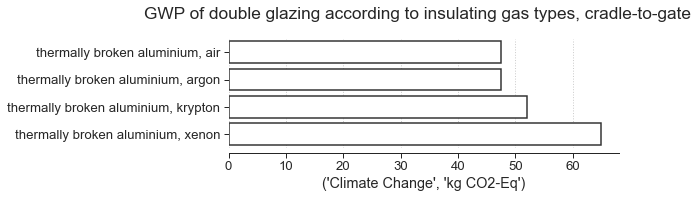

In [61]:
fig, ax = plt.subplots(figsize=(7, 2))

sns.barplot(data=df_impacts_gas,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_gas.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of double glazing according to insulating gas types, cradle-to-gate', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

In [62]:
df_norm_impacts_gas = df_impacts_gas / df_impacts_gas.max()
df_norm_impacts_gas.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                              Climate Change Ecosystem Quality          \
Unit                                     kg CO2-Eq               CTU kg P-Eq   
Name                                                                           
thermally broken aluminium, air               0.73              0.75    0.24   
thermally broken aluminium, argon             0.73              0.75    0.24   
thermally broken aluminium, krypton           0.80              0.81    0.34   
thermally broken aluminium, xenon             1.00              1.00    1.00   

Method                                                 Human Health  \
Unit                                mol H+-Eq mol N-Eq   kg CFC-11.   
Name                                                                  
thermally broken aluminium, air          0.81     0.88         0.85   
thermally broken aluminium, argon        0.81     0.88         0.85   
thermally broken aluminium, krypton      0.85     0.92         0.87   
thermally broken aluminium, xenon        1.00     1.00         1.00   

Method                                         Resources         
Unit                                kg NMVOC-. megajoule points  
Name                                                             
thermally broken aluminium, air           0.86      0.61   0.73  
thermally broken aluminium, argon         0.86      0.61   0.73  
thermally broken aluminium, krypton       0.91      0.68   0.77  
thermally broken aluminium, xenon         1.00      1.00   1.00

## Comparative LCA of Different Designs for IGU, Cradle-to-Gate

In [63]:
inv_igus = [act for act in bw.Database("exldb_igu")
            if 'market' in act['name']
            and ('glazing' in act['name']
            or 'vacuum' in act['name'])
            ]

fu_igus = [{igu: 1} for igu in inv_igus]

fu_igus

[{'market for double glazing, lsg, coated, krypton' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, two coatings' (square meter, BE, ('building components', 'windows')): 1},
 {'market for triple glazing, lsg, two coatings, krypton' (square meter, BE, ('building components', 'windows')): 1},
 {'market for triple glazing, lsg, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for triple glazing, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, lsg, two coatings, xenon' (square meter, BE, ('building components', 'windows')): 1},
 {'market for double glazing, coated' (square meter, BE, ('building components', 'windows')): 1},
 {'market for smart glass, double glazing' (square meter, BE, ('building components', 'windows')): 1},
 {'market for single glazing, lsg, coate

In [64]:
impacts_igus = []

for igu in inv_igus:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impacts_igus.append((igu["name"], igu["location"],
                             method[1].title(), lca.score,
                             bw.methods.get(method).get('unit')))

# impacts_igus

In [65]:
df_impacts_igus = pd.DataFrame(
    impacts_igus,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impacts_igus = pd.pivot_table(
    df_impacts_igus, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [66]:
df_impacts_igus = df_impacts_igus.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impacts_igus = df_impacts_igus.reset_index()
df_impacts_igus['Name'] = (df_impacts_igus['Name']
                           .str.replace('market for ', ''))

df_impacts_igus = df_impacts_igus.set_index('Name')

In [67]:
df_impacts_igus.round(2)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                 38.42             14.62   
single glazing, lsg, coated                         39.24             15.68   
double glazing, coated                              48.74             20.18   
double glazing, lsg                                 62.89             25.58   
double glazing, lsg, coated                         64.18             27.23   
double glazing, lsg, two coatings                   65.00             28.29   
double glazing, lsg, vacuum                         66.11             24.43   
triple glazing, coated                              66.88             28.24   
double glazing, lsg, coated, krypton                69.36             28.88   
triple glazing, lsg, two coatings                   82.34             34.22   
triple glazing, lsg, coated                         82.63             36.11   
double glazing, lsg, two coatings, xenon            84.51             34.90   
triple glazing, lsg, two coatings, krypton          92.72             37.51   
triple glazing, lsg, two coatings, xenon           121.37             47.44   
smart glass, double glazing                        701.78           1678.00   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.01      0.27     0.72   
single glazing, lsg, coated                   0.01      0.27     0.73   
double glazing, coated                        0.01      0.39     1.05   
double glazing, lsg                           0.01      0.46     1.23   
double glazing, lsg, coated                   0.01      0.47     1.26   
double glazing, lsg, two coatings             0.01      0.48     1.27   
double glazing, lsg, vacuum                   0.01      0.47     1.27   
triple glazing, coated                        0.01      0.53     1.43   
double glazing, lsg, coated, krypton          0.01      0.50     1.31   
triple glazing, lsg, two coatings             0.01      0.62     1.65   
triple glazing, lsg, coated                   0.01      0.62     1.65   
double glazing, lsg, two coatings, xenon      0.03      0.58     1.43   
triple glazing, lsg, two coatings, krypton    0.02      0.67     1.75   
triple glazing, lsg, two coatings, xenon      0.05      0.83     1.96   
smart glass, double glazing                   0.23      3.30     9.87   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                 0.0       0.18    645.18   
single glazing, lsg, coated                         0.0       0.18    662.13   
double glazing, coated                              0.0       0.25    659.20   
double glazing, lsg                                 0.0       0.30    983.63   
double glazing, lsg, coated                         0.0       0.31   1010.23   
double glazing, lsg, two coatings                   0.0       0.31   1027.19   
double glazing, lsg, vacuum                         0.0       0.31   1037.07   
triple glazing, coated                              0.0       0.34    905.72   
double glazing, lsg, coated, krypton                0.0       0.32   1092.32   
triple glazing, lsg, two coatings                   0.0       0.40   1261.57   
triple glazing, lsg, coated                         0.0       0.40   1261.47   
double glazing, lsg, two coatings, xenon            0.0       0.35   1482.80   
triple glazing, lsg, two coatings, krypton          0.0       

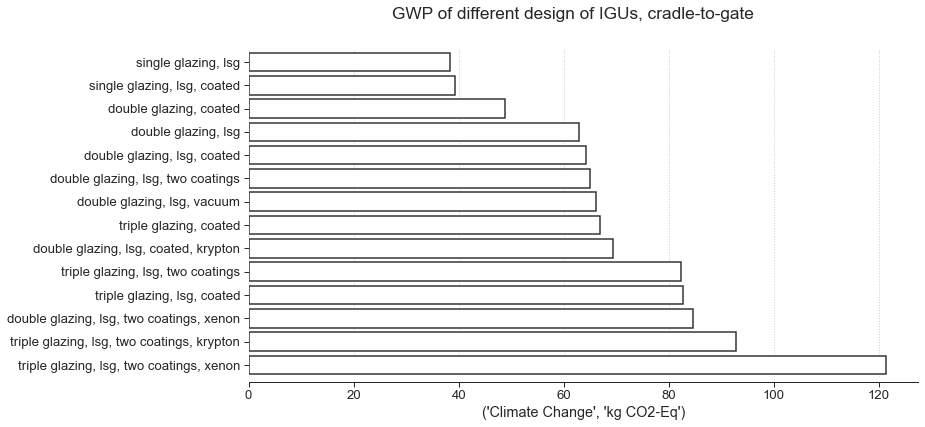

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

df_impacts_igus_wo_smartg = df_impacts_igus.drop(
    "smart glass, double glazing", axis=0
)

sns.barplot(data=df_impacts_igus_wo_smartg,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_igus_wo_smartg.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different design of IGUs, cradle-to-gate')
sns.despine(left=True, offset=5)
plt.show()

In [69]:
df_norm_impacts_igus_wo_smartg = (
    df_impacts_igus_wo_smartg / df_impacts_igus_wo_smartg.max()
)

df_norm_impacts_igus_wo_smartg.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                  0.32              0.31   
single glazing, lsg, coated                          0.32              0.33   
double glazing, coated                               0.40              0.43   
double glazing, lsg                                  0.52              0.54   
double glazing, lsg, coated                          0.53              0.57   
double glazing, lsg, two coatings                    0.54              0.60   
double glazing, lsg, vacuum                          0.54              0.51   
triple glazing, coated                               0.55              0.60   
double glazing, lsg, coated, krypton                 0.57              0.61   
triple glazing, lsg, two coatings                    0.68              0.72   
triple glazing, lsg, coated                          0.68              0.76   
double glazing, lsg, two coatings, xenon             0.70              0.74   
triple glazing, lsg, two coatings, krypton           0.76              0.79   
triple glazing, lsg, two coatings, xenon             1.00              1.00   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.11      0.32     0.36   
single glazing, lsg, coated                   0.11      0.33     0.37   
double glazing, coated                        0.11      0.47     0.53   
double glazing, lsg                           0.16      0.56     0.63   
double glazing, lsg, coated                   0.17      0.57     0.64   
double glazing, lsg, two coatings             0.18      0.58     0.65   
double glazing, lsg, vacuum                   0.17      0.57     0.65   
triple glazing, coated                        0.15      0.65     0.73   
double glazing, lsg, coated, krypton          0.22      0.60     0.67   
triple glazing, lsg, two coatings             0.22      0.75     0.84   
triple glazing, lsg, coated                   0.22      0.75     0.84   
double glazing, lsg, two coatings, xenon      0.57      0.70     0.73   
triple glazing, lsg, two coatings, krypton    0.33      0.81     0.89   
triple glazing, lsg, two coatings, xenon      1.00      1.00     1.00   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                0.47       0.36      0.30   
single glazing, lsg, coated                        0.48       0.37      0.30   
double glazing, coated                             0.42       0.52      0.30   
double glazing, lsg                                0.69       0.62      0.45   
double glazing, lsg, coated                        0.70       0.63      0.46   
double glazing, lsg, two coatings                  0.70       0.64      0.47   
double glazing, lsg, vacuum                        0.71       0.64      0.48   
triple glazing, coated                             0.57       0.71      0.42   
double glazing, lsg, coated, krypton               0.71       0.66      0.50   
triple glazing, lsg, two coatings                  0.84       0.82      0.58   
triple glazing, lsg, coated                        0.86       0.82      0.58   
double glazing, lsg, two coatings, xenon           0.78       0.73      0.68   
triple glazing, lsg, two coatings, krypton         0.87       0.88      0.66   
triple glazing, lsg, two coatings, xenon           1.00       1.00      1.00   

Method                                             
U

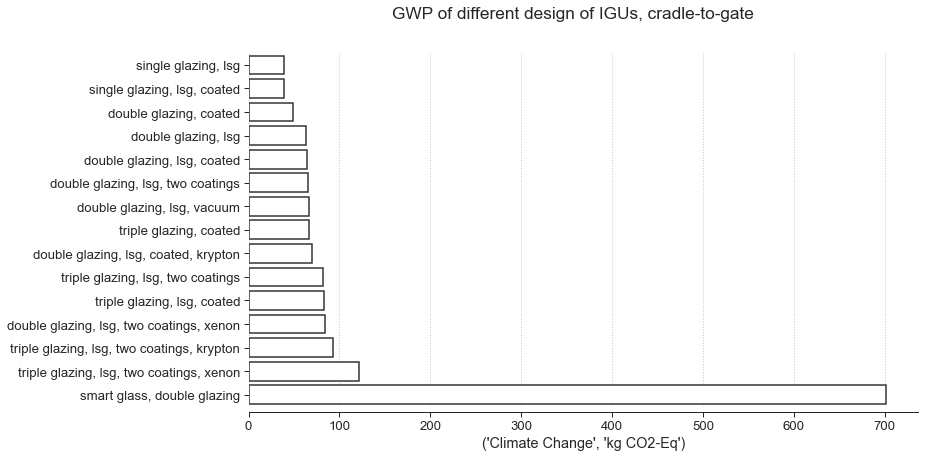

In [70]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(data=df_impacts_igus,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impacts_igus.index,
            color="white", edgecolor=".2", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different design of IGUs, cradle-to-gate')
sns.despine(left=True, offset=5)
plt.show()

In [71]:
df_norm_impacts_igus = df_impacts_igus / df_impacts_igus.max()
df_norm_impacts_igus.round(2).sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True)

Method                                     Climate Change Ecosystem Quality  \
Unit                                            kg CO2-Eq               CTU   
Name                                                                          
single glazing, lsg                                  0.05              0.01   
single glazing, lsg, coated                          0.06              0.01   
double glazing, coated                               0.07              0.01   
double glazing, lsg                                  0.09              0.02   
double glazing, lsg, coated                          0.09              0.02   
double glazing, lsg, two coatings                    0.09              0.02   
double glazing, lsg, vacuum                          0.09              0.01   
triple glazing, coated                               0.10              0.02   
double glazing, lsg, coated, krypton                 0.10              0.02   
triple glazing, lsg, two coatings                    0.12              0.02   
triple glazing, lsg, coated                          0.12              0.02   
double glazing, lsg, two coatings, xenon             0.12              0.02   
triple glazing, lsg, two coatings, krypton           0.13              0.02   
triple glazing, lsg, two coatings, xenon             0.17              0.03   
smart glass, double glazing                          1.00              1.00   

Method                                                                 \
Unit                                       kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                    
single glazing, lsg                           0.02      0.08     0.07   
single glazing, lsg, coated                   0.02      0.08     0.07   
double glazing, coated                        0.02      0.12     0.11   
double glazing, lsg                           0.03      0.14     0.12   
double glazing, lsg, coated                   0.04      0.14     0.13   
double glazing, lsg, two coatings             0.04      0.14     0.13   
double glazing, lsg, vacuum                   0.04      0.14     0.13   
triple glazing, coated                        0.03      0.16     0.15   
double glazing, lsg, coated, krypton          0.05      0.15     0.13   
triple glazing, lsg, two coatings             0.05      0.19     0.17   
triple glazing, lsg, coated                   0.05      0.19     0.17   
double glazing, lsg, two coatings, xenon      0.12      0.18     0.15   
triple glazing, lsg, two coatings, krypton    0.07      0.20     0.18   
triple glazing, lsg, two coatings, xenon      0.21      0.25     0.20   
smart glass, double glazing                   1.00      1.00     1.00   

Method                                     Human Health            Resources  \
Unit                                         kg CFC-11. kg NMVOC-. megajoule   
Name                                                                           
single glazing, lsg                                0.04       0.06      0.06   
single glazing, lsg, coated                        0.04       0.06      0.06   
double glazing, coated                             0.04       0.09      0.06   
double glazing, lsg                                0.06       0.11      0.09   
double glazing, lsg, coated                        0.06       0.11      0.09   
double glazing, lsg, two coatings                  0.06       0.11      0.09   
double glazing, lsg, vacuum                        0.06       0.11      0.10   
triple glazing, coated                             0.05       0.12      0.08   
double glazing, lsg, coated, krypton               0.06       0.11      0.10   
triple glazing, lsg, two coatings                  0.07       0.14      0.12   
triple glazing, lsg, coated                        0.08       0.14      0.12   
double glazing, lsg, two coatings, xenon           0.07       0.12      0.14   
triple glazing, lsg, two coatings, krypton         0.08       

# Import Results from the BEM

## Recover data saved in csv files from previous simulations:

To read directly the csv file and work from them instead of relaunching the energy simulation (Please note that this does not prevent the simulations from being run again. To do this, change the run_all boolean variable above. If the simulations are rerun, the new results will overwrite the old ones saved in the csv files):

Dataframe with all energy usage data per simulation run:

Retrieve the data from the csv. The simulation_postprocess function will merge the new results by overwriting the old ones, or simply add the new ones if they did not exist yet.

In [72]:
# Open the df_end_use_allsteps from the csv file:
# Avoid re-running energy simulations (time consuming):
if os.path.isfile('outputs\steps_dir\df_end_use_allsteps.csv'):
    df_end_use_allsteps_csv = (
        pd.read_csv('outputs\steps_dir\df_end_use_allsteps.csv'))
    df_end_use_allsteps_csv = df_end_use_allsteps_csv.pivot_table(
        values='0', index=['EndUse'], columns=['Run name', 'FuelType'])

    df_end_use_allsteps = df_end_use_allsteps_csv

A function to recover df_step dataframes saved as csv, i.e. DataFrame with the main assumptions and results (natural gas and electricity) specific to each simulation run:

To assess the indirect impact of glazing replacement on energy use in the building, the natural gas and electricity use results for each scenario are subtracted by the initial scenario, where the exact same glazing is kept. 

In [73]:
def recover_df_step(n_step, df_step):
    """
    If a df_step.csv exists, recover it as a dataframe wich replace 
    the one currently in use in the notebook.
    Avoid re-running energy simulation (time consuming).

    Parameters
    ----------
    n_step: number of the step
    df_step: a dataframe. followed by a number (e.g. step4), 
    identify the step with simulation runs and main results

    Returns
    -------
    df_step: update with csv data or exactly the same as the one in the input

    """

    # Does the csv exist
    # and check if the existing df_step includes simulation results:
    if os.path.isfile(f"outputs\steps_dir\df_step"+str(n_step)+".csv"):
        df_step = (
            pd.read_csv(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            .set_index(['name']))

        print("df_step ", n_step, "updated with csv data")
    else:
        print("existing df_step ", n_step, "kept in place")

    # Subtraction of energy use by that in the initial scenario:
    if not df_step.loc[df_step["glazing"] == "dg_init_bronze"].empty:
        i_gas = float(
            df_step.loc[df_step["glazing"] == "dg_init_bronze", "natural_gas"])
        i_elec = float(
            df_step.loc[df_step["glazing"] == "dg_init_bronze", "elec_use"])

        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

    else:
        print("DG_init not in step ", n_step,
              "! energy use not substracted by dg_init!")

    return df_step

## Recover the df_step dataframes:

In [74]:
df_step1 = recover_df_step(1, df_step1)
df_step2 = recover_df_step(2, df_step2)
df_step3 = recover_df_step(3, df_step3)
df_step4 = recover_df_step(4, df_step4)
df_step5 = recover_df_step(5, df_step5)
df_step6 = recover_df_step(6, df_step6)
df_step7 = recover_df_step(7, df_step7)
df_step8 = recover_df_step(8, df_step8)
df_step9 = recover_df_step(9, df_step9)
df_step10 = recover_df_step(10, df_step10)
df_step11 = recover_df_step(11, df_step11)
df_step12 = recover_df_step(12, df_step12)
df_step13 = recover_df_step(13, df_step13)
df_step14 = recover_df_step(14, df_step14)
df_step15 = recover_df_step(15, df_step15)
df_step16 = recover_df_step(16, df_step16)
df_step17 = recover_df_step(17, df_step17)
df_step18 = recover_df_step(18, df_step18)
df_step19 = recover_df_step(19, df_step19)

df_step  1 updated with csv data
df_step  2 updated with csv data
df_step  3 updated with csv data
df_step  4 updated with csv data
df_step  5 updated with csv data
df_step  6 updated with csv data
df_step  7 updated with csv data
df_step  8 updated with csv data
df_step  9 updated with csv data
df_step  10 updated with csv data
df_step  11 updated with csv data
df_step  12 updated with csv data
df_step  13 updated with csv data
df_step  14 updated with csv data
df_step  15 updated with csv data
df_step  16 updated with csv data
df_step  17 updated with csv data
df_step  18 updated with csv data
df_step  19 updated with csv data


# Impact Assessment of the Whole Life Cycle of Curtain Walls Retrofitting

## Setup of the LCA

First, we define the activity of dismantling, and thus disposal, of the existing curtain wall:

In [75]:
out_old_cw = exldb_cw.get('dismantling_cw_old_dg')
# Check:
print('My activity is:\n', out_old_cw)

My activity is:
 'curtain wall, dismantling, old double glazing' (square meter, BE, ('building components', 'windows'))


Then we define the production activity of the new curtain wall:

In [76]:
prod_cw = exldb_cw.get('production_cw')
# Check:
print('My activity is:\n', prod_cw)

My activity is:
 'curtain wall, production' (square meter, BE, ('building components', 'windows'))


We define the use phase activity (not linked to production):

In [77]:
use_bldg_w_cw = exldb_cw.get('use_glazed_office_bldg')
# Check:
print('My activity is:\n', use_bldg_w_cw)

My activity is:
 'use of glazed office building, hvac and lighting' (square meter, BE, ('building components', 'windows'))


We define a use phase activity integrating the production phase:

In [78]:
prod_and_use_cw = exldb_cw.get('use_cw')
# Check:
print('My activity is:\n', prod_and_use_cw)

My activity is:
 'use of curtain wall' (square meter, BE, ('building components', 'windows'))


We define a maintenance activity:

In [79]:
repair_cw = exldb_cw.get('maintenance_cw')
# Check:
print('My activity is:\n', repair_cw)

My activity is:
 'curtain wall, maintenance' (square meter, BE, ('building components', 'windows'))


And finally, the end-of-life activity:

In [80]:
eol_cw = exldb_cw.get('eol_cw')
# Check:
print('My activity is:\n', eol_cw)

My activity is:
 'curtain wall, end of life' (square meter, BE, ('building components', 'windows'))


Define the lifespan (years):

In [81]:
lifespan = [p.amount for p in DatabaseParameter.select()
            if p.name == 'param_lifespan'][0]

## Functions to Perform the LCAs

Write a function to perform the LCA according to activities and parameter sets:

In [82]:
def lca_cw_gwp(df_step, act, fu):
    """
    Perform a simple lca for different scenarios 
    according to parameters defined in df_step

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_results: list of values for IPCC GWP
    """

    # To save results:
    ls_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing',
                             'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu}, method_ilcd_gwp)
        lca.lci()
        lca.lcia()
        ls_results.append({'run': name_scenario, 'result': lca.score})

    return ls_results

Write a function to perform a multi_method LCA, with small_methods, according to activities and parameter sets:

In [83]:
# Reminder of the reduced list of methods:
methods_small

[('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
 ('ILCD 2.0 2018 midpoint',
  'ecosystem quality',
  'freshwater and terrestrial acidification'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
 ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
 ('ILCD 2.0 2018 midpoint', 'resources', 'land use')]

In [84]:
def lca_cw_mlca_small(df_step, act, fu):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_mlca_small_results: list of values
    """

    # To save results:
    ls_mlca_small_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu})
        lca.lci()

        for method in methods_small:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_small_results.append((name_scenario,
                                          method[2].title(), lca.score,
                                          bw.methods.get(method).get('unit')))

    return ls_mlca_small_results

Write a function to perform a multi_method LCA, with full_methods, according to activities and parameter sets:

In [85]:
# Reminder of the full list of methods:
methods_full

[('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
 ('ILCD 2.0 2018 midpoint',
  'ecosystem quality',
  'freshwater and terrestrial acidification'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
 ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics'),
 ('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals'),
 ('ILCD 2.0 2018 mid

In [86]:
def lca_cw_mlca_full(df_step, act, fu):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_mlca_full_results: list of values
    """

    # To save results:
    ls_mlca_full_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu})
        lca.lci()

        for method in methods_full:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_full_results.append((name_scenario,
                                         method[2].title(), lca.score,
                                         bw.methods.get(method).get('unit')))

    return ls_mlca_full_results

A little function to transform a list of mlca_results in a DataFrame:

In [87]:
def ls_to_df_mlca(ls):
    """
    A little function to transform the ls_mlca_results 
    in a readable DataFrame

    Parameters
    ----------
    ls: the list

    Returns
    -------
    df: the DataFrame
    """

    # DataFrame to then work w/ results:
    df = pd.DataFrame(ls,
                      columns=["Name",
                               "Impact Category",
                               "Score",
                               "Unit"
                               ]
                      )

    df = pd.pivot_table(df,
                        index=["Name"],
                        columns=["Impact Category",
                                 "Unit"
                                 ],
                        values="Score"
                        )

    return df

A function to save mlca_full_results in a DataFrame, for each simulation run and LCA phase:

In [88]:
# Initialise a DataFrame:
df_mlca_full_raw_results = pd.DataFrame()

In [89]:
def ls_to_df_mlca_full(step, ls, act, df_results):
    """
    A function to append a list of mlca results in a DataFrame, 
        with values organised per simulation run (index), 
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    ls: the list of results.
    df_results: a DataFrame where LCA results will be saved.
    act: activity for which the LCA has been done.

    Returns
    -------
    df_results
    """

    # New DataFrame from list of results:
    df_temp = pd.DataFrame(ls,
                           columns=["Name",
                                    "Impact Category",
                                    "Score",
                                    "Unit"
                                    ]
                           )

    # Add information regarding the step:
    df_temp["Step"] = step
    # Add information regarding the LCA phase:
    df_temp["LCA Phase"] = str(act["name"])

    # Pivot the DataFrame:
    df_temp = pd.pivot_table(df_temp,
                             index=["Step",
                                    "Name"
                                    ],
                             columns=["LCA Phase",
                                      "Impact Category",
                                      "Unit"
                                      ],
                             values="Score"
                             )
    # Merge with existing results:
    if df_results.empty:
        df_results = df_temp
        print("empty, df_results replaced")
    else:
        # Merge by columns_to_use:
        df_results = pd.concat(
            [df_results, df_temp[~df_temp.index.isin(df_results.index)]]
        )
        df_results.update(df_temp)

    return df_results

A function to conduct a mLCA per activity and save the mlca_full_results in a DataFrame, for each simulation run and each LCA phase:

In [90]:
def full_lca_to_df(step, df_step, df_results, fu):
    """
    A function to conduct and LCA (w/ function: lca_cw_mlca_full)
        and append a list of mlca results in a DataFrame 
        (w/ function: ls_to_df_mlca_full), 
        with values organised per simulation run (index),
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    df_step: DataFrame with list of parameters and their values

    Returns
    -------
    df_results: a DataFrame where LCA results are saved,
        simulation run as index, LCA phase and impact indicators as columns.
    """

    for act in [prod_cw, use_bldg_w_cw, repair_cw, eol_cw]:
        ls = lca_cw_mlca_full(df_step, act, fu)
        df_results = ls_to_df_mlca_full(step, ls, act, df_results)

    return df_results

## Environmental Analysis, Step-by-Step

### Life Cycle Impact Assessment

Full life cycle assessment, ILCD methods, from cradle-to-grave, for each simulation run:

<font color="red">Performing the impact assessment or loading the csv file where previous results are stored?<font>

In [91]:
# Do we perform the LCIA?
calc_lcia = False

Be patient, takes time to calculate !

In [92]:
if calc_lcia:
    # LCIA calculation:
    ls_df_step = [
        df_step1, df_step2, df_step3, df_step4, df_step5,
        df_step6, df_step7, df_step8, df_step9, df_step10,
        df_step11, df_step12, df_step13, df_step14, df_step15,
        df_step16, df_step17, df_step18, df_step19
    ]

    n = 1
    for df in ls_df_step:
        step = "step_"+str(n)
        df_mlca_full_raw_results = full_lca_to_df(step, df,
                                                  df_mlca_full_raw_results, 1)
        n += 1

    # Save df_mlca_full_raw_results to csv:
    df_mlca_full_raw_results.unstack([0, 1]).to_csv(
        'outputs\steps_dir\df_mlca_full_raw_results.csv', index=True)

else:
    # Open the csv file, to avoid recalculating the impacts:
    if os.path.isfile('outputs\steps_dir\df_mlca_full_raw_results.csv'):
        df_mlca_full_raw_results = (
            pd.read_csv('outputs\steps_dir\df_mlca_full_raw_results.csv')
        )
        df_mlca_full_raw_results = df_mlca_full_raw_results.pivot_table(
            values='0',
            index=['Step', 'Name'],
            columns=['LCA Phase', 'Impact Category', 'Unit']
        )

In [93]:
df_mlca_full_raw_results

LCA Phase                 curtain wall, end of life                       \
Impact Category                Carcinogenic Effects Climate Change Total   
Unit                                           CTUh            kg CO2-Eq   
Step   Name                                                                
step_1 a_a_2126_dg_init                4.430000e-08             2.217209   
       a_b_2126_dg0                    4.430000e-08             2.217209   
       a_c_2126_sg1                    2.790000e-08             1.437564   
       a_d_2126_sg2                    2.790000e-08             1.437564   
       a_e_2126_dg1                    4.560000e-08             3.876129   
...                                             ...                  ...   
step_9 i_f_2126_dg_vacuum              6.390000e-08             7.963271   
       i_g_2126_dg_smart               4.830000e-08             5.188937   
       i_h_2126_dsf_min                7.700000e-08             6.692394   
       i_i_2126_dsf_mean               7.700000e-08             6.692394   
       i_j_2126_dsf_max                7.700000e-08             6.692394   

LCA Phase                                              \
Impact Category           Dissipated Water    Fossils   
Unit                            m3 water-.  megajoule   
Step   Name                                             
step_1 a_a_2126_dg_init           0.287208  27.764659   
       a_b_2126_dg0               0.287208  27.764659   
       a_c_2126_sg1               0.222356  16.586811   
       a_d_2126_sg2               0.222356  16.586811   
       a_e_2126_dg1               0.334008  28.038788   
...                                    ...        ...   
step_9 i_f_2126_dg_vacuum         0.809499  32.062472   
       i_g_2126_dg_smart          0.379727  28.751079   
       i_h_2126_dsf_min           0.595308  46.846113   
       i_i_2126_dsf_mean          0.595308  46.846113   
       i_j_2126_dsf_max           0.595308  46.846113   

LCA Phase                                                           \
Impact Category           Freshwater And Terrestrial Acidification   
Unit                                                     mol H+-Eq   
Step   Name                                                          
step_1 a_a_2126_dg_init                                   0.010066   
       a_b_2126_dg0                                       0.010066   
       a_c_2126_sg1                                       0.006009   
       a_d_2126_sg2                                       0.006009   
       a_e_2126_dg1                                       0.010314   
...                                                            ...   
step_9 i_f_2126_dg_vacuum                                 0.012033   
       i_g_2126_dg_smart                                  0.010702   
       i_h_2126_dsf_min                                   0.017238   
       i_i_2126_dsf_mean                                  0.017238   
       i_j_2126_dsf_max                                   0.017238   

LCA Phase                                                                   \
Impact Category           Freshwater Ecotoxicity Freshwater Eutrophication   
Unit                                         CTU                   kg P-Eq   
Step   Name                                                                  
step_1 a_a_2126_dg_init                 4.239562                  0.000168   
       a_b_2126_dg0                     4.239562                  0.000168   
       a_c_2126_sg1                     2.516453                  0.000100   
       a_d_2126_sg2                     2.516453                  0.000100   
       a_e_2126_dg1                     4.387775                  0.000172   
...                                          ...                       ...   
step_9 i_f_2126_dg_vacuum               5.148510                  0.000208   
       i_g_2126_dg_smart               25.393818                  0.000183   
       i_h_2126_

### Navigate the LCIA Result DataFrame

List of impact categories:

In [94]:
df_ilcd_methods = pd.DataFrame()
n = 0
ls_n = []
ls_ic = []
ls_ic_details = []
ls_u = []
for method in methods_full:
    ls_n.append(n + 1)
    ls_ic.append(method[1].title())
    ls_ic_details.append(method[2].title())
    ls_u.append(bw.methods.get(method).get('unit'))
    n += 1

df_ilcd_methods["Impact Category"] = ls_ic
df_ilcd_methods["Sub-Category"] = ls_ic_details
df_ilcd_methods["Unit"] = ls_u
df_ilcd_methods["#"] = ls_n

df_ilcd_methods = df_ilcd_methods.set_index(["Impact Category", "#"])
df_ilcd_methods

Sub-Category        Unit
Impact Category   #                                                       
Climate Change    1                       Climate Change Total   kg CO2-Eq
Ecosystem Quality 2                     Freshwater Ecotoxicity         CTU
                  3   Freshwater And Terrestrial Acidification   mol H+-Eq
                  4                  Freshwater Eutrophication     kg P-Eq
                  5                      Marine Eutrophication     kg N-Eq
                  6                 Terrestrial Eutrophication    mol N-Eq
Human Health      7                   Non-Carcinogenic Effects        CTUh
                  8                       Carcinogenic Effects        CTUh
                  9                         Ionising Radiation  kg U235-Eq
                  10                     Ozone Layer Depletion  kg CFC-11.
                  11              Photochemical Ozone Creation  kg NMVOC-.
                  12           Respiratory Effects, Inorganics  disease i.
Resources         13                       Minerals And Metals    kg Sb-Eq
                  14                          Dissipated Water  m3 water-.
                  15                                   Fossils   megajoule
                  16                                  Land Use      points

Select the impact category to display:

In [95]:
# Define the rank of the impact category (#):
n = 1

Select the step of analysis, with the batch of simulation runs:

In [96]:
step = "step_4"

Display LCA results:

In [97]:
ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
df_mlca_full_raw_results.loc[step].xs(ic, axis=1,
                                      level=1, drop_level=False
                                     )

LCA Phase,"curtain wall, end of life","curtain wall, maintenance","curtain wall, production","use of glazed office building, hvac and lighting"
Impact Category,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total
Unit,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
Name,,,,
d_a_2126_dg_init_vav_sd,2.217209,3.880656,630.112368,0.000000
d_b_2126_dg0_vav_sd,2.217209,3.880656,630.112368,204.854002
d_c_2126_sg1_vav_sd,1.437564,3.880656,603.238645,831.436940
d_d_2126_sg2_vav_sd,1.437564,3.880656,604.020135,19.113403
d_e_2126_dg1_vav_sd,3.876129,3.880656,634.311901,252.189284
d_f_2126_dg2_vav_sd,3.876129,3.880656,634.311901,-13.991010
d_g_2126_dg3_vav_sd,3.876129,3.880656,634.311901,9.967255


### Disposal of the Existing Curtain Wall

In [98]:
ls_mlca_oldcw_results = []

lca = bw.LCA({out_old_cw: 1})
lca.lci()
for method in methods_full:
    lca.switch_method(method)
    lca.lcia()
    ls_mlca_oldcw_results.append((method[2].title(), lca.score,
                                  bw.methods.get(method).get('unit')))

ls_mlca_oldcw_results

[('Climate Change Total', 2.2172091002291365, 'kg CO2-Eq'),
 ('Freshwater Ecotoxicity', 4.239561821320238, 'CTU'),
 ('Freshwater And Terrestrial Acidification',
  0.010066232267819946,
  'mol H+-Eq'),
 ('Freshwater Eutrophication', 0.0001679255441600641, 'kg P-Eq'),
 ('Marine Eutrophication', 0.003622959865424288, 'kg N-Eq'),
 ('Terrestrial Eutrophication', 0.039469328791174395, 'mol N-Eq'),
 ('Non-Carcinogenic Effects', 2.605556958086844e-07, 'CTUh'),
 ('Carcinogenic Effects', 4.432450539888622e-08, 'CTUh'),
 ('Ionising Radiation', 0.15424153448483702, 'kg U235-Eq'),
 ('Ozone Layer Depletion', 3.954435840042073e-07, 'kg CFC-11.'),
 ('Photochemical Ozone Creation', 0.01128339006486353, 'kg NMVOC-.'),
 ('Respiratory Effects, Inorganics', 1.6746130867451783e-07, 'disease i.'),
 ('Minerals And Metals', 3.892570538412845e-05, 'kg Sb-Eq'),
 ('Dissipated Water', 0.28720842179004896, 'm3 water-.'),
 ('Fossils', 27.764659335005696, 'megajoule'),
 ('Land Use', 39.30936081827277, 'points')]

In [99]:
df_mlca_oldcw_results = pd.DataFrame(ls_mlca_oldcw_results,
                                     columns=["Impact Category",
                                              "Score",
                                              "Unit"]
                                     )

df_mlca_oldcw_results = pd.pivot_table(df_mlca_oldcw_results,
                                       columns=["Impact Category", "Unit"],
                                       values="Score"
                                       )

df_mlca_oldcw_results

Impact Category,Carcinogenic Effects,Climate Change Total,Dissipated Water,Fossils,Freshwater And Terrestrial Acidification,Freshwater Ecotoxicity,Freshwater Eutrophication,Ionising Radiation,Land Use,Marine Eutrophication,Minerals And Metals,Non-Carcinogenic Effects,Ozone Layer Depletion,Photochemical Ozone Creation,"Respiratory Effects, Inorganics",Terrestrial Eutrophication
Unit,CTUh,kg CO2-Eq,m3 water-.,megajoule,mol H+-Eq,CTU,kg P-Eq,kg U235-Eq,points,kg N-Eq,kg Sb-Eq,CTUh,kg CFC-11.,kg NMVOC-.,disease i.,mol N-Eq
Score,4.432451e-08,2.217209,0.287208,27.764659,0.010066,4.239562,0.000168,0.154242,39.309361,0.003623,0.000039,2.605557e-07,3.954436e-07,0.011283,1.674613e-07,0.039469


# Post-Processing and Data Analysis

## Calculation of the Environmental Impact over 40 years of Service Life

In [101]:
df_lca_lifespan = pd.DataFrame(
    {'Year': np.arange(lifespan+3),
     'Step': 'ref',
     'Scenario': 'no_retrofit',
     'Impact Category': 'All',
     'Unit': 'None',
     'Score': 0
     }
)

df_lca_lifespan = df_lca_lifespan.pivot(index='Year',
                                        columns=['Step',
                                                 'Scenario',
                                                 'Impact Category',
                                                 'Unit'
                                                 ],
                                        values='Score'
                                        )

In [102]:
df_mlca_full_raw_results = df_mlca_full_raw_results.reset_index(level=0)

# Defining the columns, one for each simulation run:
for run in df_mlca_full_raw_results.index:
    n_step = df_mlca_full_raw_results["Step"].loc[run]
    for method in methods_full:
        ic = method[2].title()
        u = bw.methods.get(method).get('unit')
        # define a new column:
        df_lca_lifespan[n_step, run, ic, u] = 0

df_lca_lifespan = df_lca_lifespan.drop("ref", axis=1)

C:\Users\souvi\AppData\Local\Temp/ipykernel_44480/4152277470.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lca_lifespan[n_step, run, ic, u] = 0


In [103]:
# LCIA over the 40 years of the service life of the curtain wall:
for step, run, ic, u in df_lca_lifespan.columns:
    # First phase of the LCA, disposal of the existing curtain wall:
    df_lca_lifespan.loc[0][step, run, ic, u] = (
        df_mlca_oldcw_results[ic, u]
    )

    # Second phase, production/construction of the new curtain wall:
    df_lca_lifespan.loc[1][step, run, ic, u] = (
        df_lca_lifespan.loc[0][step, run, ic, u] +
        df_mlca_full_raw_results.loc[run][
            "curtain wall, production", ic, u
        ]
    )

    # Third phase, use of the curtain wall, indirect energy use impacts:
    for y in range(2, 42):
        df_lca_lifespan.loc[y][step, run, ic, u] = (
            df_lca_lifespan.loc[y-1][step, run, ic, u] +
            df_mlca_full_raw_results.loc[run][
                "use of glazed office building, hvac and lighting", ic, u
            ]
        )
        if (y == 12 or y == 22 or y == 32):
            # Third phase, impacts relating to maintenance, every 10y:
            df_lca_lifespan.loc[y][step, run, ic, u] += (
                df_mlca_full_raw_results.loc[run][
                    "curtain wall, maintenance", ic, u
                ]
            )

    # Last phase, end-of-life of the new curtain wall:
    df_lca_lifespan.loc[42][step, run, ic, u] = (
        df_lca_lifespan.loc[41][step, run, ic, u] +
        df_mlca_full_raw_results.loc[run][
            "curtain wall, end of life", ic, u
        ]
    )

Post-processing the LCA results to define the trajectory 2020 > 2050, with climate change:

In [105]:
# Code for the simulations run in 2020 which corresponds
# to the same configuration as the one in 2050, 
# step_14 > step_4; step_16 > step_10; step_18 > step_11:
run_2050_2020 = {
    "n_a_2126_dg_init_cc2050": "d_a_2126_dg_init_vav_sd",
    "n_b_2126_dg0_cc2050": "d_b_2126_dg0_vav_sd",
    "n_c_2126_dg4_cc2050": "d_h_2126_dg4_vav_sd",
    "n_d_2126_dg5_cc2050": "d_i_2126_dg5_vav_sd",
    "n_e_2126_dg6_cc2050": "d_j_2126_dg6_vav_sd",
    "n_f_2126_tg4_cc2050": "d_n_2126_tg4_vav_sd",
    "n_g_2126_tg5_cc2050": "d_o_2126_tg5_vav_sd",
    "n_h_2126_tg6_cc2050": "d_p_2126_tg6_vav_sd",
    "p_a_2124_dg_init_cc2050": "j_a_2124_dg_init_sd",
    "p_b_2124_dg0_cc2050": "j_b_2124_dg0_sd",
    "p_c_2124_dg4_cc2050": "j_c_2124_dg4_sd",
    "p_d_2124_dg5_cc2050": "j_d_2124_dg5_sd",
    "p_e_2124_dg6_cc2050": "j_e_2124_dg6_sd",
    "p_f_2124_tg4_cc2050": "j_f_2124_tg4_sd",
    "p_g_2124_tg5_cc2050": "j_g_2124_tg5_sd",
    "p_h_2124_tg6_cc2050": "j_h_2124_tg6_sd",
    "r_a_1927_dg_init_cc2050": "k_a_1927_dg_init_tc",
    "r_b_1927_dg0_cc2050": "k_b_1927_dg0_tc",
    "r_c_1927_dg4_cc2050": "k_c_1927_dg4_tc",
    "r_d_1927_dg5_cc2050": "k_d_1927_dg5_tc",
    "r_e_1927_dg6_cc2050": "k_e_1927_dg6_tc",
    "r_f_1927_tg4_cc2050": "k_f_1927_tg4_tc",
    "r_g_1927_tg5_cc2050": "k_g_1927_tg5_tc",
    "r_h_1927_tg6_cc2050": "k_h_1927_tg6_tc"
}

In [106]:
# Corresponding simulations 2050 > 2020:
steps_2050_2020 = {"step_14": "step_4",
                   "step_16": "step_10",
                   "step_18": "step_11"
                   }

In [107]:
# LCIA over 40years for 2050 climate change scenario:
# 2022 corresponds to y = 2
for step, run, ic, u in df_lca_lifespan.columns:
    # First step, heating 21, cooling 26:
    if step in steps_2050_2020.keys():
        # Modification of the first year in use, i.e. 2022 and not 2050:
        df_lca_lifespan.loc[2][step, run, ic, u] = (
            df_lca_lifespan.loc[2][steps_2050_2020[step], 
                                   run_2050_2020[run], 
                                   ic, 
                                   u
                                  ]
        )

        # Delete data between 2022 and 2050, i.e. y=30:
        for y in range(3, 30):
            df_lca_lifespan.loc[y][step, run, ic, u] = np.nan

        # Idem passed 2050, i.e. y=30:
        for y in range(31, 43):
            df_lca_lifespan.loc[y][step, run, ic, u] = np.nan

        # Interpolate between 2020 and 2050, and the 10 years after:
        df_lca_lifespan[step, run, ic, u].interpolate(
            method='linear',
            limit_direction='forward',
            axis=0
        )

        # Last phase, end-of-life of the new curtain wall:
        df_lca_lifespan.loc[42][step, run, ic, u] += (
            df_mlca_full_raw_results.loc[run][
                "curtain wall, end of life", ic, u
            ]
        )

In [108]:
# Rebuild df_mlca_full_raw_results:
df_mlca_full_raw_results = (
    df_mlca_full_raw_results.reset_index().set_index(["Step", "Name"])
)

In [109]:
df_lca_lifespan["step_4"].xs(
    "Climate Change Total", axis=1, level=1, drop_level=False)

Scenario,d_a_2126_dg_init_vav_sd,d_b_2126_dg0_vav_sd,d_c_2126_sg1_vav_sd,d_d_2126_sg2_vav_sd,d_e_2126_dg1_vav_sd,d_f_2126_dg2_vav_sd,d_g_2126_dg3_vav_sd,d_h_2126_dg4_vav_sd,d_i_2126_dg5_vav_sd,d_j_2126_dg6_vav_sd,d_k_2126_tg1_vav_sd,d_l_2126_tg2_vav_sd,d_m_2126_tg3_vav_sd,d_n_2126_tg4_vav_sd,d_o_2126_tg5_vav_sd,d_p_2126_tg6_vav_sd
Impact Category,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total,Climate Change Total
Unit,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq,kg CO2-Eq
Year,,,,,,,,,,,,,,,,
0.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1.0,632,632,605,606,636,636,636,636,636,637,662,662,662,661,661,661
2.0,632,836,1436,625,888,622,645,384,487,606,934,703,680,529,552,697
3.0,632,1040,2267,644,1140,608,654,132,338,575,1206,744,698,397,443,733
4.0,632,1244,3098,663,1392,594,663,-119,189,544,1478,785,716,265,334,769
5.0,632,1448,3929,682,1644,580,672,-370,40,513,1750,826,734,133,225,805
6.0,632,1652,4760,701,1896,566,681,-621,-108,482,2022,867,752,1,116,841


## Setup to Create the Graphs

Define a function to divide/multiply the y-axis by a thousand, if needed:

In [110]:
def thousand_divide(x, pos):
    # The two args are the value and tick position
    return '%1.1f' % (x*1e-3)

def thousand_multiply(x, pos):
    # The two args are the value and tick position
    return '%1.1f' % (x*1e+3)

In [111]:
formatter = FuncFormatter(thousand_divide)

In [112]:
def plot_lca_40(step_lines, step_area, impact_cat,
                ls_lineplot, ls_fill_btw,
                ylim_min, ylim_max, y_format,
                title
                ):
    """
    Plot the curves according to the data defined in ls_lineplot 
        (i.e. sg, dg, dg_init, tg). Add a "shadow" (with fill_between)
        which represents the range of values btw two curves 
        of other scenarios.
        x = 42 years of service life

    Parameters
    ----------
    step_lines: a string, step where the simulations and LCA results 
        are taken from, plot as curves
    step_area: a string, step where the simulations and LCA results 
        are taken from, plot as an area with fill_between
    impact_cat: an int which correspond to the reference number 
        in df_ilcd_methods
    ls_lineplot: list of simulation runs to plot, according to simplified 
        igu name (i.e. sg, dg, dg_init, tg)
    ls_fill_btw: dic with the simulation run code (e.g. "a_a_2126_dg_init")
        to define the two curves that "frame" the fill_between area.
    ylim_min: an integer, minimum value of the y-axis.
    ylim_max: an integer, maximum value of the y-axis.
    y_format: FuncFormatter defined to scale the y-axis values.
    title: string, title of the graph.


    Returns
    -------
    df: the DataFrame with impact values at year = 42
    """

    ls_impact_year42 = {}

    # Defining the LCA results to plot:
    ic = df_ilcd_methods.xs(impact_cat, level=1)["Sub-Category"][0]
    df_lca_step = df_lca_lifespan[step_lines].xs(ic,
                                                 axis=1, level=1,
                                                 drop_level=False
                                                 )

    df_lca_step_area = df_lca_lifespan[step_area].xs(ic,
                                                     axis=1, level=1,
                                                     drop_level=False
                                                     )

    fig, ax = plt.subplots(figsize=(9, 3))
    
    # To fill area between two curves, two variables are defined:
    a = 0
    b = 0
    
    for run, i, u in df_lca_step_area.columns:
        if run == ls_fill_btw["up"]:
            a = run

        if run == ls_fill_btw["down"]:
            b = run

        # We plot the "shadow" of other simulations:
        if (a != 0) and (b != 0):
            ax.fill_between(np.array(df_lca_step_area.index),
                            np.array(df_lca_step_area[a, i, u]),
                            np.array(df_lca_step_area[b, i, u]),
                            color="ghostwhite", alpha=0.05)

    # Evolution of the GWP over 40 years:
    for run, i, u in df_lca_step.columns:
        # Then, we plot the curves:
        if ('dg_init' in run) and ('dg_init' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, i, u].tolist(),
                         color='black',
                         ax=ax
                         )

        elif ('dg0' in run) and ('dg0' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, i, u].tolist(),
                         color='black',
                         linestyle='--',
                         ax=ax
                         )

        elif ('sg' in run) and ('sg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, i, u].tolist(),
                         color='lightsalmon',
                         ax=ax
                         )

        elif ('dg' in run) and ('dg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, i, u].tolist(),
                         color='darksalmon',
                         ax=ax
                         )

        elif ('tg' in run) and ('tg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, i, u].tolist(),
                         color='firebrick',
                         ax=ax
                         )
        else:
            continue

        # Update the dictionary with value at year = 42:
        ls_impact_year42[run] = df_lca_step.loc[42][run, i, u]

    ax.set_xlim(0, 42)
    ax.axhline(y=0, c='grey', linestyle='-', linewidth=0.75)

    ax.set_ylim(-ylim_min, ylim_max)
    plt.yticks(np.arange(-ylim_min, ylim_max+1, 10000))
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    
    if formatter != 0:
        ax.yaxis.set_major_formatter(y_format)

    style_ax(ax)
    
    fig.suptitle(title, weight='light', y=1.1, ha='center', fontsize=15)
    sns.despine(offset=5, bottom=True, left=True)
    plt.show()

    df = pd.DataFrame.from_dict(ls_impact_year42, orient='index',
                                columns=['impact at year = 42, '+str(u)])

    return df

Reminder of the impact categories and their reference numbers:

In [113]:
df_ilcd_methods

Sub-Category        Unit
Impact Category   #                                                       
Climate Change    1                       Climate Change Total   kg CO2-Eq
Ecosystem Quality 2                     Freshwater Ecotoxicity         CTU
                  3   Freshwater And Terrestrial Acidification   mol H+-Eq
                  4                  Freshwater Eutrophication     kg P-Eq
                  5                      Marine Eutrophication     kg N-Eq
                  6                 Terrestrial Eutrophication    mol N-Eq
Human Health      7                   Non-Carcinogenic Effects        CTUh
                  8                       Carcinogenic Effects        CTUh
                  9                         Ionising Radiation  kg U235-Eq
                  10                     Ozone Layer Depletion  kg CFC-11.
                  11              Photochemical Ozone Creation  kg NMVOC-.
                  12           Respiratory Effects, Inorganics  disease i.
Resources         13                       Minerals And Metals    kg Sb-Eq
                  14                          Dissipated Water  m3 water-.
                  15                                   Fossils   megajoule
                  16                                  Land Use      points

## Step 1-3: Initial Configuration with Different Glazing Types

### Step 1: Different glazing types, w/o shading devices and thermal curtain, fan coil chiller w/ boiler

In [114]:
# Define the simulation step, plot as curves:
step_lines = "step_1"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg_init', 'sg', "dg0"]
ls_fill_btw = {"up":'', "down":''}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 1: Initial Configuration, comparison of sg and clear dg,"+
         "GWP, ton CO2-Eq"
        )

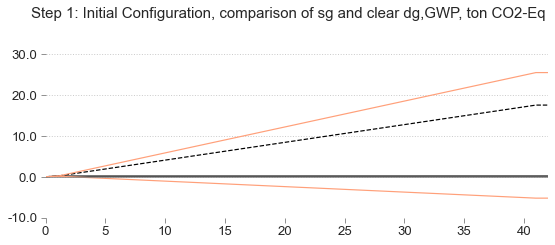

,"impact at year = 42, kg CO2-Eq"
a_a_2126_dg_init,172
a_b_2126_dg0,17572
a_c_2126_sg1,25544
a_d_2126_sg2,-5251


In [115]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [116]:
# Define the simulation step, plot as curves:
step_lines = "step_1"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg', "dg0"]
ls_fill_btw = {"up":'a_c_2126_sg1', "down":'a_d_2126_sg2'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 1: Initial Configuration, comparison of dg, "+
         "GWP, ton CO2-Eq"
        )

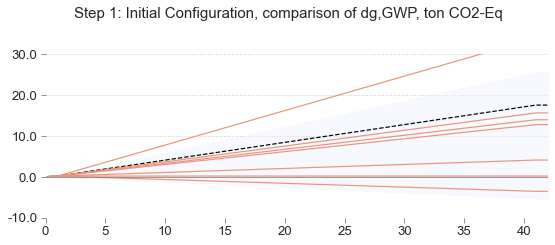

,"impact at year = 42, kg CO2-Eq"
a_a_2126_dg_init,172
a_b_2126_dg0,17572
a_e_2126_dg1,33977
a_f_2126_dg2,13977
a_g_2126_dg3,15657
a_h_2126_dg4,-3580
a_i_2126_dg5,4097
a_j_2126_dg6,12778


In [117]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [118]:
# Define the simulation step, plot as curves:
step_lines = "step_1"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['tg']
ls_fill_btw = {"up":'a_g_2126_dg3', "down":'a_h_2126_dg4'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 1: Initial Configuration, comparison of tg,"+
         "GWP, ton CO2-Eq"
        )

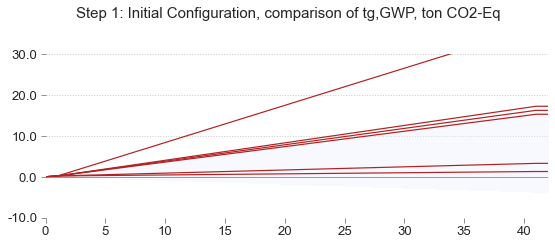

,"impact at year = 42, kg CO2-Eq"
a_k_2126_tg1,36644
a_l_2126_tg2,17284
a_m_2126_tg3,15324
a_n_2126_tg4,1284
a_o_2126_tg5,3284
a_p_2126_tg6,16284


In [119]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

### Step 2: Different glazing types, with shading devices, fan coil chiller w/ boiler

In [120]:
# Define the simulation step, plot as curves:
step_lines = "step_2"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg_init', 'sg', "dg0"]
ls_fill_btw = {"up":'a_c_2126_sg1', "down":'a_d_2126_sg2'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 2: comparison of sg and clear dg, with shading device,"+
         "with, in background, sg w/o shading devices, "
         "GWP, ton CO2-Eq"
        )

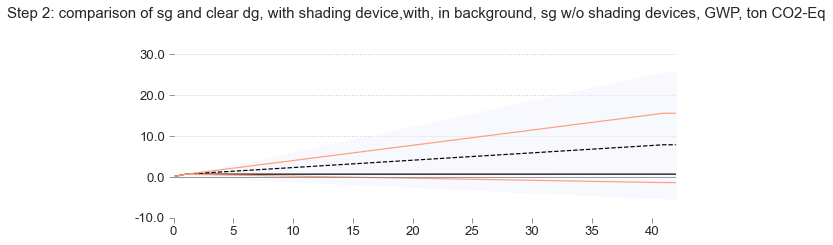

,"impact at year = 42, kg CO2-Eq"
b_a_2126_dg_init_sd,643
b_b_2126_dg0_sd,7843
b_c_2126_sg1_sd,15575
b_d_2126_sg2_sd,-1432


In [121]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [122]:
# Define the simulation step, plot as curves:
step_lines = "step_2"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg']
ls_fill_btw = {"up":'a_g_2126_dg3', "down":'a_h_2126_dg4'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 2: comparison of dg, with shading device,"+
         "with, in background, dg w/o shading devices, "
         "GWP, ton CO2-Eq"
        )

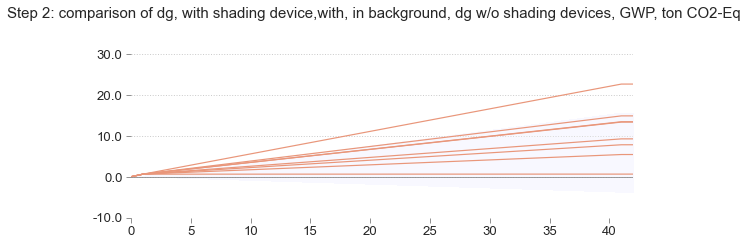

,"impact at year = 42, kg CO2-Eq"
b_a_2126_dg_init_sd,643
b_b_2126_dg0_sd,7843
b_e_2126_dg1_sd,22728
b_f_2126_dg2_sd,13408
b_g_2126_dg3_sd,14928
b_h_2126_dg4_sd,5448
b_i_2126_dg5_sd,9288
b_j_2126_dg6_sd,13489


In [123]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [124]:
# Define the simulation step, plot as curves:
step_lines = "step_2"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['tg']
ls_fill_btw = {"up":'a_l_2126_tg2', "down":'a_n_2126_tg4'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 2: comparison of tg, with shading device,"+
         "with, in background, tg w/o shading devices, "
         "GWP, ton CO2-Eq"
        )

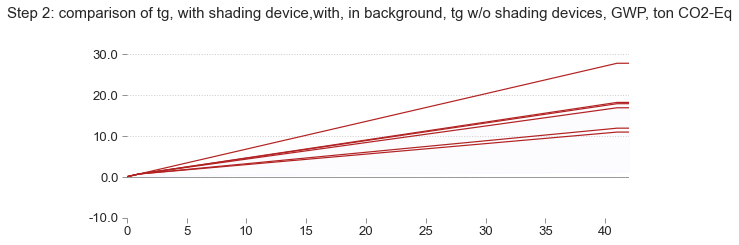

,"impact at year = 42, kg CO2-Eq"
b_k_2126_tg1_sd,27835
b_l_2126_tg2_sd,17915
b_m_2126_tg3_sd,16915
b_n_2126_tg4_sd,10954
b_o_2126_tg5_sd,11914
b_p_2126_tg6_sd,18234


In [125]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

### Step 3: Different glazing types, with overhangs and thermal curtain, fan coil chiller w/ boiler

In [126]:
# Define the simulation step, plot as curves:
step_lines = "step_3"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg_init', 'sg', "dg0"]
ls_fill_btw = {"up":'a_c_2126_sg1', "down":'a_d_2126_sg2'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 3: comparison of sg and clear dg, with overhangs "+
         "and thermal curtain, with, in background, sg w/o shading devices, "
         "GWP, ton CO2-Eq"
        )

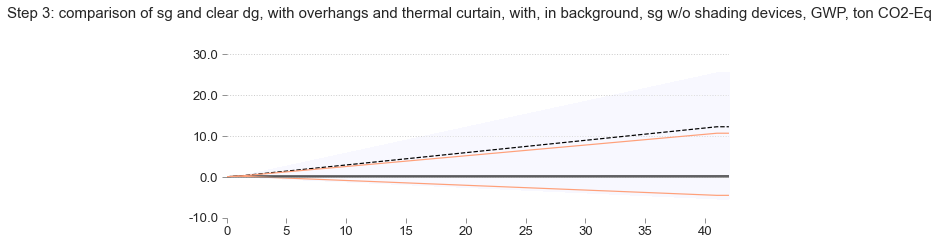

,"impact at year = 42, kg CO2-Eq"
c_a_2126_dg_init_tc,179
c_b_2126_dg0_tc,12259
c_c_2126_sg1_tc,10671
c_d_2126_sg2_tc,-4565


In [127]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [128]:
# Define the simulation step, plot as curves:
step_lines = "step_3"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg']
ls_fill_btw = {"up":'a_g_2126_dg3', "down":'a_h_2126_dg4'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 3: comparison of dg, with overhangs and thermal curtain,"+
         "with, in background, dg w/o shading devices, "
         "GWP, ton CO2-Eq"
        )

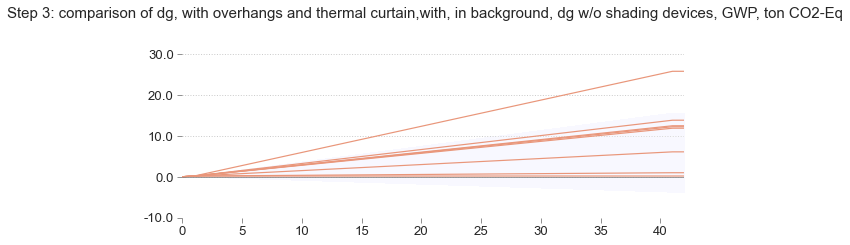

,"impact at year = 42, kg CO2-Eq"
c_a_2126_dg_init_tc,179
c_b_2126_dg0_tc,12259
c_e_2126_dg1_tc,25864
c_f_2126_dg2_tc,12504
c_g_2126_dg3_tc,13864
c_h_2126_dg4_tc,984
c_i_2126_dg5_tc,6104
c_j_2126_dg6_tc,11905


In [129]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [130]:
# Define the simulation step, plot as curves:
step_lines = "step_2"
# Define the simulation step, plot as area:
step_area = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['tg']
ls_fill_btw = {"up":'a_l_2126_tg2', "down":'a_n_2126_tg4'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 3: comparison of tg, with overhangs and thermal curtain, "+
         "with, in background, tg w/o shading devices, "
         "GWP, ton CO2-Eq"
        )

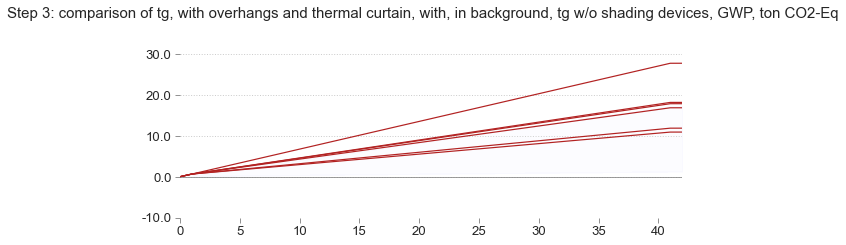

,"impact at year = 42, kg CO2-Eq"
b_k_2126_tg1_sd,27835
b_l_2126_tg2_sd,17915
b_m_2126_tg3_sd,16915
b_n_2126_tg4_sd,10954
b_o_2126_tg5_sd,11914
b_p_2126_tg6_sd,18234


In [131]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

## Steps 4-5: HVAC System Optimisation, VAV and VRF

### Step 4: Efficient VAV HVAC System, with Exterior Shading Device

In [132]:
# Define the simulation step, plot as curves:
step_lines = "step_4"
# Define the simulation step, plot as area:
step_area = "step_2"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg_init', 'sg', "dg0"]
ls_fill_btw = {"up":'b_c_2126_sg1_sd', "down":'b_d_2126_sg2_sd'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 4: VAV system, sg and clear dg, with shading device,"+
         "with, in background, sg w shading devices, initial HVAC system, "
         "GWP, ton CO2-Eq"
        )

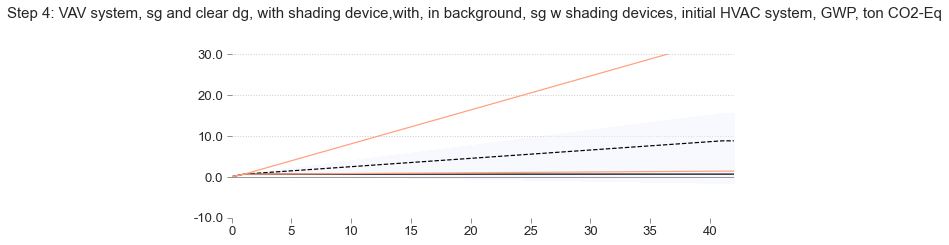

,"impact at year = 42, kg CO2-Eq"
d_a_2126_dg_init_vav_sd,643
d_b_2126_dg0_vav_sd,8803
d_c_2126_sg1_vav_sd,33855
d_d_2126_sg2_vav_sd,1376


In [133]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [134]:
# Define the simulation step, plot as curves:
step_lines = "step_4"
# Define the simulation step, plot as area:
step_area = "step_2"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg']
ls_fill_btw = {"up":'b_e_2126_dg1_sd', "down":'b_h_2126_dg4_sd'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 4: VAV system, double glazin, with shading device,"+
         "with, in background, dg w/ shading devices, initial HVAC system, "
         "GWP, ton CO2-Eq"
        )

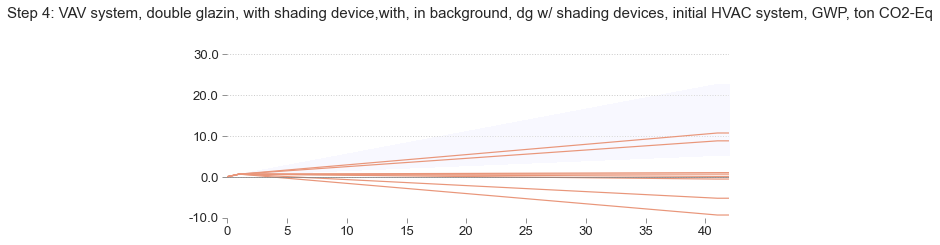

,"impact at year = 42, kg CO2-Eq"
d_a_2126_dg_init_vav_sd,643
d_b_2126_dg0_vav_sd,8803
d_e_2126_dg1_vav_sd,10728
d_f_2126_dg2_vav_sd,88
d_g_2126_dg3_vav_sd,1008
d_h_2126_dg4_vav_sd,-9390
d_i_2126_dg5_vav_sd,-5272
d_j_2126_dg6_vav_sd,-568


In [135]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [136]:
# Define the simulation step, plot as curves:
step_lines = "step_4"
# Define the simulation step, plot as area:
step_area = "step_2"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['tg']
ls_fill_btw = {"up":'b_k_2126_tg1_sd', "down":'b_n_2126_tg4_sd'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 4: VAV system, triple glazing, with shading device,"+
         "with, in background, tg w/ shading devices, initial HVAC system, "
         "GWP, ton CO2-Eq"
        )

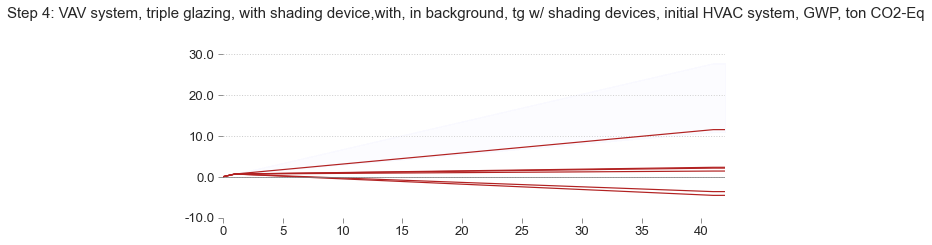

,"impact at year = 42, kg CO2-Eq"
d_k_2126_tg1_vav_sd,11555
d_l_2126_tg2_vav_sd,2315
d_m_2126_tg3_vav_sd,1395
d_n_2126_tg4_vav_sd,-4567
d_o_2126_tg5_vav_sd,-3648
d_p_2126_tg6_vav_sd,2114


In [137]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

### Step 5: Efficient VAV HVAC System, with Overhangs and Thermal Curtain

In [138]:
# Define the simulation step, plot as curves:
step_lines = "step_5"
# Define the simulation step, plot as area:
step_area = "step_2"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg_init', 'sg', "dg0"]
ls_fill_btw = {"up":'b_c_2126_sg1_sd', "down":'b_d_2126_sg2_sd'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 5: VAV system, sg and clear dg, with overhangs "+
         "and thermal curtain, with, in background, dg, initial HVAC system, "
         "GWP, ton CO2-Eq"
        )

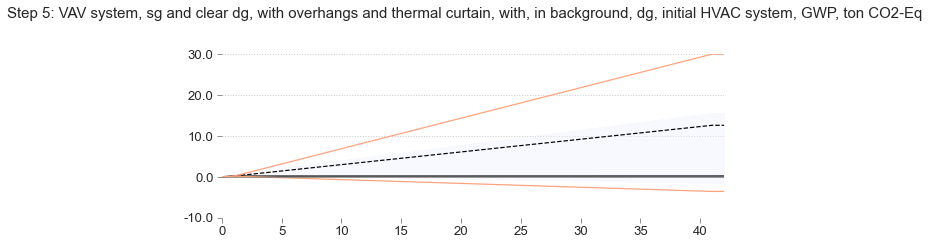

,"impact at year = 42, kg CO2-Eq"
e_a_2126_dg_init_vav_tc,179
e_b_2126_dg0_vav_tc,12619
e_c_2126_sg1_vav_tc,30071
e_d_2126_sg2_vav_tc,-3605


In [139]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [140]:
# Define the simulation step, plot as curves:
step_lines = "step_5"
# Define the simulation step, plot as area:
step_area = "step_2"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['dg']
ls_fill_btw = {"up":'b_e_2126_dg1_sd', "down":'b_h_2126_dg4_sd'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 5: VAV system, double glazing, with overhangs "+
         "and thermal curtain, with, in background, dg, initial HVAC system, "
         "GWP, ton CO2-Eq"
        )

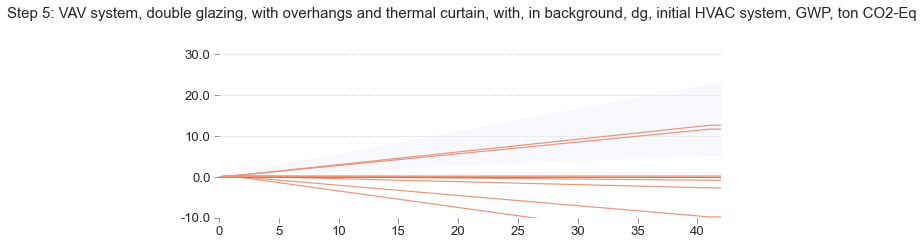

,"impact at year = 42, kg CO2-Eq"
e_a_2126_dg_init_vav_tc,179
e_b_2126_dg0_vav_tc,12619
e_e_2126_dg1_vav_tc,11664
e_f_2126_dg2_vav_tc,-858
e_g_2126_dg3_vav_tc,-152
e_h_2126_dg4_vav_tc,-16052
e_i_2126_dg5_vav_tc,-9852
e_j_2126_dg6_vav_tc,-2733


In [141]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

In [142]:
# Define the simulation step, plot as curves:
step_lines = "step_5"
# Define the simulation step, plot as area:
step_area = "step_2"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_lineplot = ['tg']
ls_fill_btw = {"up":'b_k_2126_tg1_sd', "down":'b_n_2126_tg4_sd'}
# If useful to scale the y-axis 
#(0, or FuncFormatter(thousand_divide), or FuncFormatter(thousand_multiply)):
formatter = FuncFormatter(thousand_divide)
# Define the title of the graph:
title = ("Step 5: VAV system, triple glazing, with overhangs "+
         "and thermal curtain, with, in background, tg, initial HVAC system, "
         "GWP, ton CO2-Eq"
        )

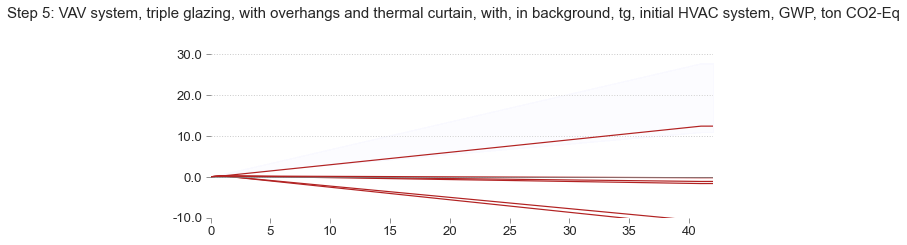

,"impact at year = 42, kg CO2-Eq"
e_k_2126_tg1_vav_tc,12411
e_l_2126_tg2_vav_tc,-242
e_m_2126_tg3_vav_tc,-1669
e_n_2126_tg4_vav_tc,-12106
e_o_2126_tg5_vav_tc,-10866
e_p_2126_tg6_vav_tc,-1151


In [143]:
plot_lca_40(step_lines, step_area,
            impact_cat, 
            ls_lineplot, ls_fill_btw, 
            10000, 30000, formatter,
            title
           )

# Energy Mix: Sensitivity Analysis

In [ ]:
# List of activities to change, in this case electricity markets:
locations = ["FR", "DE", "PL", "NL", "CH"]

act_name = "market for electricity, low voltage"

el_markets = [('ecoinvent 3.7 cut-off', act['code'])
              for act in eicutdb.search(act_name, limit=200)
              for location in locations
              if act_name in act['name'] and location in act['location']
              and "US-FRCC" not in act['location']
              and "US-SERC" not in act['location']]

# Remove "market for electricity, low voltage, label-certified" for CH:
el_markets.pop(5)

el_markets

In [ ]:
act_cw = exldb_cw.get('use_cw')

# Printing the exchanges
print('My activity is:\n', act_cw,
      '\n-------\nAnd its exchanges:\n-------')

for i in list(act_cw.exchanges()):
    print(i['type'])
    print(i)
    print(i['input'])
    print('-------')

In [ ]:
exc = list(act_cw.exchanges())[10]
exc

In [ ]:
# Make a copy of the activity, substitute the background process
# save and calculate:

cw_elec_results = []

for m in el_markets[0:2]:
    act_cw_copy = act_cw.copy()
    exc['input'] = m
    exc.save()
    lca = LCA({act_cw_copy: 1}, ('IPCC 2013', 'climate change', 'GWP 100a'))
    lca.lci()
    lca.lcia()
    cw_elec_results.append(lca.score)

In [ ]:
# Results for Belgium:
lca = LCA({act_cw: 1}, method_ilcd_gwp)
lca.lci()
lca.lcia()
be_cw_elec_result = lca.score

In [ ]:
be_cw_elec_result

In [ ]:
np.mean([(i/be_cw_elec_result) for i in cw_elec_results])

In [ ]:
pd.DataFrame(cw_elec_results).describe()

In [ ]:
plt.boxplot(cw_elec_results)
plt.ylabel(methods[('IPCC 2013', 'climate change', 'GWP 100a')]['unit'])
plt.xlabel('El Production')